In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, CatBoostRegressor
import optuna
from sklearn.model_selection import train_test_split

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### catboost

In [2]:
def CatBoostC(train_x, test_x, train_y, test_y, config, cat_feature):
    
    clf = CatBoostClassifier(**config, verbose = 0)
    clf.fit(train_x, train_y, cat_features = cat_feature)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


def CatBoostR(train_x, test_x, train_y, test_y, config, cat_feature):
    
    reg = CatBoostRegressor(**config, verbose = 0)
    reg.fit(train_x, train_y, cat_features = cat_feature)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})

    return result


def runall_CatBoostC(num_set, trainset_x, test_x, trainset_y, test_y, config, cat_feature):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config
        
        result = CatBoostC(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config, cat_feature)
        table = cf_matrix(result, trainset_y[f'set{i}'])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})

    return table_set
    
    
def runall_CatBoostR(num_set, trainset_x, test_x, trainset_y, test_y, config, cat_feature, thres_target = 'Recall', 
                     threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = CatBoostR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config, cat_feature)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})

    return pr_dict, table_set

### optuna

In [3]:
def CatBoost_creator(train_data, mode, cat_feature = [], num_valid = 3, label = 'GB') :

    def objective(trial) :
    
        param_1 = {
            'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
            'iterations': trial.suggest_int('iterations', 100, 300, step = 50),
            'depth': trial.suggest_int('depth', 2, 10, step = 2),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.325, step = 0.05),
            'subsample': trial.suggest_float('subsample', 0.5, 0.9, step = 0.2),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10) 
        }

        if param_1['grow_policy'] == 'Depthwise' :
            param_2 = {
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 3, 30, step = 3)
            }
            param = {**param_1, **param_2}
        
        elif param_1['grow_policy'] == 'Lossguide' :
            param_3 = {
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 3, 30, step = 3),
                'max_leaves': trial.suggest_int('max_leaves', 15, 50, step = 5)
            }
            param = {**param_1, **param_3}
        
        else :
            param = param_1

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)

            if mode == 'C':
                result = CatBoostC(train_x, valid_x, train_y, valid_y, param, cat_feature)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                precision = table['Precision']
                beta = 0.75
                fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision)
                result_list.append(fscore)

            elif mode == 'R':
                result = CatBoostR(train_x, valid_x, train_y, valid_y, param, cat_feature)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)

    return objective

## 

### loading training & testing data

In [4]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (1404, 88)  balance ratio: 1.0
Dimension of dataset 2 : (1928, 88)  balance ratio: 1.0
Dimension of dataset 3 : (1514, 88)  balance ratio: 1.0
Dimension of dataset 4 : (1378, 88)  balance ratio: 1.0
Dimension of dataset 5 : (1370, 88)  balance ratio: 1.01
Dimension of dataset 6 : (1662, 88)  balance ratio: 0.71
Dimension of dataset 7 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 8 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 9 : (759, 88)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (2304, 97)  balance ratio: 1.0
Dimension of dataset 2 : (3150, 97)  balance ratio: 1.0
Dimension of dataset 3 : (2480, 97)  balance ratio: 1.0
Dimension of dataset 4 : (2258, 97)  balance ratio: 1.0
Dimension of dataset 5 : (2271, 97)  balance ratio: 0.99
Dimensio

### search for best hyperparameter

In [5]:
best_paramC, all_scoreC = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'C', 
                                     TPE_multi = True, 
                                     n_iter = 200, 
                                     filename = 'runhist_array_m2m4_m5_3criteria_CatBoost', 
                                     creator = CatBoost_creator
                                    )

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-12 20:46:34,146] A new study created in memory with name: no-name-da2195f1-62cd-497c-b7cf-1025d715ad57


Dataset0 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.5 
Recall: 0.013157894736842105 
Aging Rate: 5.090742484791407e-05
[W 2021-12-12 20:46:40,025] Trial 0 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
[W 2021-12-12 20:46:47,634] Trial 1 failed, because the objective function returned nan.
Precision: 0.7941176470588235 
Recall: 0.7105263157894737 
Aging Rate: 0.0017308524448290783
Precision: 0.8923076923076924 
Recall: 0.7631578947368421 
Aging Rate: 0.0016544913075572073
Precision: 0.8767123287671232 
Recall: 0.8421052631578947 
Aging Rate: 0.0018581210069488635
[I 2021-12-12 20:47:09,821] Trial 2 finished with value: 0.8222830622377809 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.035646083626477636}. Best is trial 2 with value: 0.8222830622377809.
Precision: 0.8 
Recall: 0.3157894736842105 
Aging Rate: 0.000763611372718711


Training has stopped (degenerate solution on iteration 97, probably too small l2-regularization, try to increase it)


Precision: 0.8387096774193549 
Recall: 0.34210526315789475 
Aging Rate: 0.000789065085142668


Training has stopped (degenerate solution on iteration 38, probably too small l2-regularization, try to increase it)


Precision: 0.16666666666666666 
Recall: 0.013157894736842105 
Aging Rate: 0.0001527222745437422
[I 2021-12-12 20:47:15,521] Trial 3 finished with value: 0.3661208857347245 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.001811238689988144, 'min_data_in_leaf': 24}. Best is trial 2 with value: 0.8222830622377809.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:47:37,422] Trial 4 failed, because the objective function returned nan.


Training has stopped (degenerate solution on iteration 77, probably too small l2-regularization, try to increase it)


Precision: 0.125 
Recall: 0.013157894736842105 
Aging Rate: 0.00020362969939165628


Training has stopped (degenerate solution on iteration 47, probably too small l2-regularization, try to increase it)


Precision: 0.5 
Recall: 0.013157894736842105 
Aging Rate: 5.090742484791407e-05


Training has stopped (degenerate solution on iteration 54, probably too small l2-regularization, try to increase it)


Precision: 0.5 
Recall: 0.013157894736842105 
Aging Rate: 5.090742484791407e-05
[I 2021-12-12 20:47:46,870] Trial 5 finished with value: 0.03354019319151278 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.0025826918530410066, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 2 with value: 0.8222830622377809.
Precision: 0.7397260273972602 
Recall: 0.7105263157894737 
Aging Rate: 0.0018581210069488635


Training has stopped (degenerate solution on iteration 100, probably too small l2-regularization, try to increase it)


Precision: 0.875 
Recall: 0.27631578947368424 
Aging Rate: 0.0006108890981749688
Precision: 0.6111111111111112 
Recall: 0.5789473684210527 
Aging Rate: 0.0018326672945249065
[I 2021-12-12 20:48:13,904] Trial 6 finished with value: 0.606547752892701 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.0023221441823323952, 'min_data_in_leaf': 30}. Best is trial 2 with value: 0.8222830622377809.
Precision: 0.9272727272727272 
Recall: 0.6710526315789473 
Aging Rate: 0.0013999541833176368
Precision: 0.9361702127659575 
Recall: 0.5789473684210527 
Aging Rate: 0.0011963244839259806
Precision: 0.9230769230769231 
Recall: 0.631578947368421 
Aging Rate: 0.0013235930460457658
[I 2021-12-12 20:48:47,211] Trial 7 finished with value: 0.7909302775428201 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.21009772531227286, 'min_data_in_l

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:49:21,815] Trial 9 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.05263157894736842 
Aging Rate: 0.00010181484969582814
Precision: 0.8888888888888888 
Recall: 0.10526315789473684 
Aging Rate: 0.0002290834118156133
Precision: 1.0 
Recall: 0.11842105263157894 
Aging Rate: 0.0002290834118156133
[I 2021-12-12 20:49:39,716] Trial 10 finished with value: 0.21565828790892727 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.03989990346584358}. Best is trial 2 with value: 0.8222830622377809.
Precision: 0.975609756097561 
Recall: 0.5263157894736842 
Aging Rate: 0.0010436022093822384
Precision: 0.9 
Recall: 0.35526315789473684 
Aging Rate: 0.000763611372718711
Precision: 0.9428571428571428 
Recall: 0.4342105263157895 
Aging Rate: 0.0008908799348384962
[I 2021-12-12 20:50:30,135] Trial 11 finished with va

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.5 
Recall: 0.013157894736842105 
Aging Rate: 5.090742484791407e-05
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
[W 2021-12-12 20:50:48,923] Trial 12 failed, because the objective function returned nan.
Precision: 0.7758620689655172 
Recall: 0.5921052631578947 
Aging Rate: 0.001476315320589508


Training has stopped (degenerate solution on iteration 124, probably too small l2-regularization, try to increase it)


Precision: 0.5625 
Recall: 0.23684210526315788 
Aging Rate: 0.0008145187975666251


Training has stopped (degenerate solution on iteration 119, probably too small l2-regularization, try to increase it)


Precision: 0.6388888888888888 
Recall: 0.3026315789473684 
Aging Rate: 0.0009163336472624532
[I 2021-12-12 20:51:04,337] Trial 13 finished with value: 0.5101647352699246 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0027561761561408415, 'min_data_in_leaf': 6, 'max_leaves': 15}. Best is trial 2 with value: 0.8222830622377809.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 5.090742484791407e-05
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 5.090742484791407e-05
[W 2021-12-12 20:51:22,905] Trial 14 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.5 
Recall: 0.013157894736842105 
Aging Rate: 5.090742484791407e-05
[W 2021-12-12 20:51:33,584] Trial 15 failed, because the objective function returned nan.


Training has stopped (degenerate solution on iteration 170, probably too small l2-regularization, try to increase it)


Precision: 0.9166666666666666 
Recall: 0.7236842105263158 
Aging Rate: 0.001527222745437422


Training has stopped (degenerate solution on iteration 62, probably too small l2-regularization, try to increase it)


Precision: 0.4117647058823529 
Recall: 0.09210526315789473 
Aging Rate: 0.00043271311120726956


Training has stopped (degenerate solution on iteration 13, probably too small l2-regularization, try to increase it)
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:51:42,714] Trial 16 failed, because the objective function returned nan.
Precision: 0.9333333333333333 
Recall: 0.18421052631578946 
Aging Rate: 0.0003818056863593555
Precision: 0.6666666666666666 
Recall: 0.13157894736842105 
Aging Rate: 0.0003818056863593555
Precision: 1.0 
Recall: 0.17105263157894737 
Aging Rate: 0.00033089826151144145
[I 2021-12-12 20:52:32,765] Trial 17 finished with value: 0.3379001417118009 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.2641282341122558, 'min_data_in_leaf': 21}. Best is trial 2 with value: 0.8222830622377809.
Precision: 0.896551724137931 
Recall: 0.6842105263157895 
Aging Rate: 0.001476315320589508
Precision: 0.8076923076923077 
Recall: 0.8289473684210527 
Aging Rate: 0.0019853895690686487
Precision: 0.8484848484848485 
Recall: 0.7368421052631579 
Aging Rate: 0.0016799450199811643
[I 2021-12-12 20:5

Training has stopped (degenerate solution on iteration 8, probably too small l2-regularization, try to increase it)


Precision: 0.3333333333333333 
Recall: 0.05263157894736842 
Aging Rate: 0.0003054445490874844
[I 2021-12-12 20:53:16,938] Trial 19 finished with value: 0.5816800507711309 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.001275471522698537}. Best is trial 2 with value: 0.8222830622377809.
Precision: 0.8461538461538461 
Recall: 0.7236842105263158 
Aging Rate: 0.0016544913075572073
Precision: 0.8333333333333334 
Recall: 0.7894736842105263 
Aging Rate: 0.0018326672945249065
Precision: 0.8888888888888888 
Recall: 0.7368421052631579 
Aging Rate: 0.0016035838827092933
[I 2021-12-12 20:54:07,901] Trial 20 finished with value: 0.8139934790017985 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0016227942749048724}. Best is trial 2 with value: 0.8222830622377809.


Training has stopped (degenerate solution on iteration 15, probably too small l2-regularization, try to increase it)


Precision: 0.38095238095238093 
Recall: 0.10526315789473684 
Aging Rate: 0.0005345279609030977
Precision: 0.9090909090909091 
Recall: 0.6578947368421053 
Aging Rate: 0.0013999541833176368
Precision: 0.921875 
Recall: 0.7763157894736842 
Aging Rate: 0.0016290375951332503
[I 2021-12-12 20:54:41,213] Trial 21 finished with value: 0.6196314353729138 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.004402218900841301}. Best is trial 2 with value: 0.8222830622377809.
Precision: 0.9661016949152542 
Recall: 0.75 
Aging Rate: 0.001501769033013465
Precision: 0.9508196721311475 
Recall: 0.7631578947368421 
Aging Rate: 0.001552676457861379
Precision: 0.9180327868852459 
Recall: 0.7368421052631579 
Aging Rate: 0.001552676457861379
[I 2021-12-12 20:55:19,373] Trial 22 finished with value: 0.8640581983955479 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
[W 2021-12-12 20:57:19,462] Trial 26 failed, because the objective function returned nan.
Precision: 0.5 
Recall: 0.013157894736842105 
Aging Rate: 5.090742484791407e-05
Precision: 0.5 
Recall: 0.02631578947368421 
Aging Rate: 0.00010181484969582814
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
[I 2021-12-12 20:57:42,237] Trial 27 finished with value: 0.04582513553923346 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.4662345567322632}. Best is trial 22 with value: 0.8640581983955479.
Precision: 0.0 
Recall: 0.0 
Aging Rate: 5.090742484791407e-05
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 20:58:08,320] Trial 28 failed, because the objective function returned nan.
Precision: 0.9615384615384616 
Recall: 0.32894736842105265 
Aging Rate: 0.0006617965230228829
Precision: 0.9259259259259259 
Recall: 0.32894736842105265 
Aging Rate: 0.0006872502354468399
Precision: 0.9583333333333334 
Recall: 0.3026315789473684 
Aging Rate: 0.0006108890981749688
[I 2021-12-12 20:58:23,855] Trial 29 finished with value: 0.5555357245281131 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.17307847533473253}. Best is trial 22 with value: 0.8640581983955479.
Precision: 0.7209302325581395 
Recall: 0.40789473684210525 
Aging Rate: 0.0010945096342301526


Training has stopped (degenerate solution on iteration 16, probably too small l2-regularization, try to increase it)
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.8157894736842105 
Recall: 0.40789473684210525 
Aging Rate: 0.0009672410721103674
[W 2021-12-12 20:58:44,577] Trial 30 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
Precision: 0.0 
Recall: 0.0 
Aging Rate: 2.5453712423957035e-05
[W 2021-12-12 20:59:19,898] Trial 31 failed, because the objective function returned nan.
Precision: 0.9130434782608695 
Recall: 0.8289473684210527 
Aging Rate: 0.0017563061572530353
Precision: 0.875 
Recall: 0.8289473684210527 
Aging Rate: 0.0018326672945249065
Precision: 0.8923076923076924 
Recall: 0.7631578947368421 
Aging Rate: 0.0016544913075572073
[I 2021-12-12 21:00:21,288] Trial 32 finished with value: 0.859927635286403 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample

Training has stopped (degenerate solution on iteration 40, probably too small l2-regularization, try to increase it)


Precision: 0.45454545454545453 
Recall: 0.06578947368421052 
Aging Rate: 0.0002799908366635274


Training has stopped (degenerate solution on iteration 121, probably too small l2-regularization, try to increase it)


Precision: 0.9117647058823529 
Recall: 0.40789473684210525 
Aging Rate: 0.0008654262224145391


Training has stopped (degenerate solution on iteration 207, probably too small l2-regularization, try to increase it)


Precision: 0.8301886792452831 
Recall: 0.5789473684210527 
Aging Rate: 0.0013490467584697228
[I 2021-12-12 21:02:34,127] Trial 35 finished with value: 0.49815733162077486 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.001348871550683208}. Best is trial 34 with value: 0.8722419625472199.
Precision: 0.8382352941176471 
Recall: 0.75 
Aging Rate: 0.0017308524448290783
Precision: 0.7162162162162162 
Recall: 0.6973684210526315 
Aging Rate: 0.0018835747193728205
Precision: 0.7866666666666666 
Recall: 0.7763157894736842 
Aging Rate: 0.0019090284317967775
[I 2021-12-12 21:03:26,946] Trial 36 finished with value: 0.7654665174261966 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.04122836057413855, 'min_data_in_leaf': 12, 'max_leaves': 50}. Best is trial 34 with value: 0.8722419625472199.
Pr

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:07:00,411] Trial 40 failed, because the objective function returned nan.
Precision: 0.9333333333333333 
Recall: 0.7368421052631579 
Aging Rate: 0.001527222745437422
Precision: 0.8714285714285714 
Recall: 0.8026315789473685 
Aging Rate: 0.0017817598696769925
Precision: 0.9285714285714286 
Recall: 0.6842105263157895 
Aging Rate: 0.0014254078957415938
[I 2021-12-12 21:07:39,875] Trial 41 finished with value: 0.8399033331173106 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.016878904640603595}. Best is trial 34 with value: 0.8722419625472199.
Precision: 0.9433962264150944 
Recall: 0.6578947368421053 
Aging Rate: 0.0013490467584697228
Precision: 0.9090909090909091 
Recall: 0.6578947368421053 
Aging Rate: 0.0013999541833176368
Precision: 0.8870967741935484 
Recall: 0.7236842105263158 
Aging Rate: 0.001578130170285336
[I 2021-12-12 21:08:21,98

Precision: 0.9655172413793104 
Recall: 0.7368421052631579 
Aging Rate: 0.001476315320589508
Precision: 0.890625 
Recall: 0.75 
Aging Rate: 0.0016290375951332503
Precision: 0.9 
Recall: 0.8289473684210527 
Aging Rate: 0.0017817598696769925
[I 2021-12-12 21:24:58,774] Trial 55 finished with value: 0.8586184509363625 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.4916497738308344, 'min_data_in_leaf': 12}. Best is trial 50 with value: 0.8816038835447153.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:25:39,440] Trial 56 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.17105263157894737 
Aging Rate: 0.00033089826151144145
Precision: 0.8181818181818182 
Recall: 0.11842105263157894 
Aging Rate: 0.0002799908366635274
Precision: 1.0 
Recall: 0.18421052631578946 
Aging Rate: 0.00035635197393539845
[I 2021-12-12 21:26:09,973] Trial 57 finished with value: 0.33714674594252564 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 5.115052622827949, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 50 with value: 0.8816038835447153.
Precision: 0.8571428571428571 
Recall: 0.7105263157894737 
Aging Rate: 0.0016035838827092933
Precision: 0.9180327868852459 
Recall: 0.7368421052631579 
Aging Rate: 0.001552676457861379
Precision: 0.8909090909090909 
Recall: 0.6447368421052632 
Aging Rate: 0.0013999541833176368
[I 2021-12-1

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:28:45,173] Trial 60 failed, because the objective function returned nan.
Precision: 0.9782608695652174 
Recall: 0.5921052631578947 
Aging Rate: 0.0011708707715020236
Precision: 0.8823529411764706 
Recall: 0.5921052631578947 
Aging Rate: 0.0012981393336218088
Precision: 0.8958333333333334 
Recall: 0.5657894736842105 
Aging Rate: 0.0012217781963499376
[I 2021-12-12 21:29:37,146] Trial 61 finished with value: 0.7608705492828411 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 4.712119948770093, 'min_data_in_leaf': 15}. Best is trial 50 with value: 0.8816038835447153.
Precision: 0.7142857142857143 
Recall: 0.06578947368421052 
Aging Rate: 0.00017817598696769923


Training has stopped (degenerate solution on iteration 10, probably too small l2-regularization, try to increase it)
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


Training has stopped (degenerate solution on iteration 41, probably too small l2-regularization, try to increase it)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 5.090742484791407e-05
[W 2021-12-12 21:29:45,534] Trial 62 failed, because the objective function returned nan.
Precision: 0.8208955223880597 
Recall: 0.7236842105263158 
Aging Rate: 0.0017053987324051213
Precision: 0.9814814814814815 
Recall: 0.6973684210526315 
Aging Rate: 0.0013745004708936798
Precision: 0.9122807017543859 
Recall: 0.6842105263157895 
Aging Rate: 0.001450861608165551
[I 2021-12-12 21:30:34,776] Trial 63 finished with value: 0.817836368687725 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.017025430612243955, 'min_data_in_leaf': 18}. Best is trial 50 with value: 0.8816038835447153.
Precision: 1.0 
Recall: 0.07894736842105263 
Aging Rate: 0.0001527222745437422
Precision: 1.0 
Recall: 0.07894736842105263 
Aging Rate: 0.0001527222745437422
Precision: 0.8888888888888888 
Recall: 0.10526315789473684 
Aging Rate: 0.000229083411815613

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 21:31:36,102] Trial 65 failed, because the objective function returned nan.
Precision: 0.9411764705882353 
Recall: 0.21052631578947367 
Aging Rate: 0.00043271311120726956
Precision: 0.875 
Recall: 0.18421052631578946 
Aging Rate: 0.00040725939878331256
Precision: 0.75 
Recall: 0.23684210526315788 
Aging Rate: 0.0006108890981749688
[I 2021-12-12 21:32:12,774] Trial 66 finished with value: 0.40403292732655355 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.1842594138298625}. Best is trial 50 with value: 0.8816038835447153.
Precision: 1.0 
Recall: 0.27631578947368424 
Aging Rate: 0.0005345279609030977
Precision: 0.9444444444444444 
Recall: 0.2236842105263158 
Aging Rate: 0.0004581668236312266
Precision: 1.0 
Recall: 0.34210526315789475 
Aging Rate: 0.0006617965230228829
[I 2021-12-12 21:32:34,254] Trial 67 finished with value: 0.

Training has stopped (degenerate solution on iteration 8, probably too small l2-regularization, try to increase it)
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


Training has stopped (degenerate solution on iteration 26, probably too small l2-regularization, try to increase it)


Precision: 0.5 
Recall: 0.013157894736842105 
Aging Rate: 5.090742484791407e-05
Precision: 0.7090909090909091 
Recall: 0.5131578947368421 
Aging Rate: 0.0013999541833176368
[W 2021-12-12 21:33:46,237] Trial 69 failed, because the objective function returned nan.
Precision: 0.9428571428571428 
Recall: 0.868421052631579 
Aging Rate: 0.0017817598696769925
Precision: 0.967741935483871 
Recall: 0.7894736842105263 
Aging Rate: 0.001578130170285336
Precision: 0.9821428571428571 
Recall: 0.7236842105263158 
Aging Rate: 0.0014254078957415938
[I 2021-12-12 21:34:27,500] Trial 70 finished with value: 0.8932917925747336 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.058106416589899824}. Best is trial 70 with value: 0.8932917925747336.
Precision: 0.8888888888888888 
Recall: 0.8421052631578947 
Aging Rate: 0.0018326672945249065
Precision: 1.0 
Recall: 0.8289473684210527 
Aging Rate: 0.0016035838827092933
Prec

Training has stopped (degenerate solution on iteration 38, probably too small l2-regularization, try to increase it)


Precision: 0.5 
Recall: 0.06578947368421052 
Aging Rate: 0.00025453712423957034


Training has stopped (degenerate solution on iteration 207, probably too small l2-regularization, try to increase it)


Precision: 0.08403361344537816 
Recall: 0.2631578947368421 
Aging Rate: 0.006057983556901774
Precision: 0.8055555555555556 
Recall: 0.7631578947368421 
Aging Rate: 0.0018326672945249065
[I 2021-12-12 21:43:47,894] Trial 83 finished with value: 0.349724535917806 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0026152368427266154, 'min_data_in_leaf': 15}. Best is trial 71 with value: 0.8990551149828825.
Precision: 0.8285714285714286 
Recall: 0.7631578947368421 
Aging Rate: 0.0017817598696769925
Precision: 0.8923076923076924 
Recall: 0.7631578947368421 
Aging Rate: 0.0016544913075572073
Precision: 0.8266666666666667 
Recall: 0.8157894736842105 
Aging Rate: 0.0019090284317967775
[I 2021-12-12 21:44:37,571] Trial 84 finished with value: 0.8225181029312957 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.00505733606061117

Precision: 0.9024390243902439 
Recall: 0.4868421052631579 
Aging Rate: 0.0010436022093822384
Precision: 0.967741935483871 
Recall: 0.39473684210526316 
Aging Rate: 0.000789065085142668
Precision: 0.9166666666666666 
Recall: 0.4342105263157895 
Aging Rate: 0.0009163336472624532
[I 2021-12-12 21:54:23,893] Trial 98 finished with value: 0.6602178775211914 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.05725473578836648, 'min_data_in_leaf': 24}. Best is trial 71 with value: 0.8990551149828825.


Training has stopped (degenerate solution on iteration 27, probably too small l2-regularization, try to increase it)


Precision: 0.6666666666666666 
Recall: 0.02631578947368421 
Aging Rate: 7.63611372718711e-05
Precision: 0.9193548387096774 
Recall: 0.75 
Aging Rate: 0.001578130170285336
Precision: 0.8666666666666667 
Recall: 0.6842105263157895 
Aging Rate: 0.001527222745437422
[I 2021-12-12 21:54:52,819] Trial 99 finished with value: 0.5697663107736637 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.0024081514500835398}. Best is trial 71 with value: 0.8990551149828825.
Precision: 0.9705882352941176 
Recall: 0.868421052631579 
Aging Rate: 0.0017308524448290783
Precision: 0.9354838709677419 
Recall: 0.7631578947368421 
Aging Rate: 0.001578130170285336
Precision: 0.873015873015873 
Recall: 0.7236842105263158 
Aging Rate: 0.0016035838827092933
[I 2021-12-12 21:55:38,733] Trial 100 finished with value: 0.8696513756456737 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'l

Precision: 0.9473684210526315 
Recall: 0.23684210526315788 
Aging Rate: 0.0004836205360551837
Precision: 0.9 
Recall: 0.11842105263157894 
Aging Rate: 0.00025453712423957034
Precision: 0.9444444444444444 
Recall: 0.2236842105263158 
Aging Rate: 0.0004581668236312266
[I 2021-12-12 22:04:13,911] Trial 114 finished with value: 0.3864320210411874 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 4.5737002978142725}. Best is trial 71 with value: 0.8990551149828825.
Precision: 0.9375 
Recall: 0.7894736842105263 
Aging Rate: 0.0016290375951332503
Precision: 0.9230769230769231 
Recall: 0.7894736842105263 
Aging Rate: 0.0016544913075572073
Precision: 0.8243243243243243 
Recall: 0.8026315789473685 
Aging Rate: 0.0018835747193728205
[I 2021-12-12 22:04:46,330] Trial 115 finished with value: 0.8548903008001948 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:07:01,425] Trial 119 failed, because the objective function returned nan.
Precision: 0.8823529411764706 
Recall: 0.5921052631578947 
Aging Rate: 0.0012981393336218088
Precision: 0.8823529411764706 
Recall: 0.5921052631578947 
Aging Rate: 0.0012981393336218088
Precision: 0.8545454545454545 
Recall: 0.618421052631579 
Aging Rate: 0.0013999541833176368
[I 2021-12-12 22:07:28,643] Trial 120 finished with value: 0.7504262574595054 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.12214402652375977, 'min_data_in_leaf': 3}. Best is trial 71 with value: 0.8990551149828825.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.0 
Recall: 0.0 
Aging Rate: 2.5453712423957035e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:07:42,479] Trial 121 failed, because the objective function returned nan.


Training has stopped (degenerate solution on iteration 96, probably too small l2-regularization, try to increase it)
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:07:51,735] Trial 122 failed, because the objective function returned nan.
Precision: 0.890625 
Recall: 0.75 
Aging Rate: 0.0016290375951332503
Precision: 0.9074074074074074 
Recall: 0.6447368421052632 
Aging Rate: 0.0013745004708936798
Precision: 0.9818181818181818 
Recall: 0.7105263157894737 
Aging Rate: 0.0013999541833176368
[I 2021-12-12 22:08:29,534] Trial 123 finished with value: 0.8296080527462762 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.58716289111915, 'min_data_in_leaf': 9, 'max_leaves': 25}. Best is trial 71 with value: 0.8990551149828825.
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
Precision: 0.0 
Recall: 0.0 
Aging Rate: 2.5453712423957035e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:08:39,336] Trial 124 failed, because the objective function returned nan.
Precision: 0.0 
Recall: 0.0 
Aging Rate: 5.090742484791407e-05
Precision: 0.0 
Recall: 0.0 
Aging Rate: 2.5453712423957035e-05
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 5.090742484791407e-05
[W 2021-12-12 22:08:56,097] Trial 125 failed, because the objective function returned nan.
Precision: 0.0 
Recall: 0.0 
Aging Rate: 2.5453712423957035e-05
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
[W 2021-12-12 22:09:12,321] Trial 126 failed, because the objective function returned nan.
Precision: 0.9545454545454546 
Recall: 0.27631578947368424 
Aging Rate: 0.0005599816733270548
Precision: 0.9047619047619048 
Recall: 0.25 
Aging Rate: 0.0005345279609030977
Precision: 0.9444444444444444 
Recall: 0.2236842105263158 
Aging Rate: 0.000458

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:11:23,564] Trial 130 failed, because the objective function returned nan.
Precision: 0.9473684210526315 
Recall: 0.7105263157894737 
Aging Rate: 0.001450861608165551
Precision: 0.9285714285714286 
Recall: 0.8552631578947368 
Aging Rate: 0.0017817598696769925
Precision: 0.9 
Recall: 0.7105263157894737 
Aging Rate: 0.001527222745437422
[I 2021-12-12 22:12:04,955] Trial 131 finished with value: 0.8559361993602973 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.17808638610731686}. Best is trial 71 with value: 0.8990551149828825.
Precision: 0.9104477611940298 
Recall: 0.8026315789473685 
Aging Rate: 0.0017053987324051213
Precision: 0.9411764705882353 
Recall: 0.8421052631578947 
Aging Rate: 0.0017308524448290783
Precision: 0.7808219178082192 
Recall: 0.75 
Aging Rate: 0.0018581210069488635
[I 2021-12-12 22:12:51,789] Trial 132 finished with v

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:13:00,151] Trial 133 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.3333333333333333 
Recall: 0.013157894736842105 
Aging Rate: 7.63611372718711e-05
Precision: 0.5 
Recall: 0.013157894736842105 
Aging Rate: 5.090742484791407e-05
[W 2021-12-12 22:13:24,448] Trial 134 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


Training has stopped (degenerate solution on iteration 56, probably too small l2-regularization, try to increase it)
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:13:34,312] Trial 135 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.7894736842105263 
Aging Rate: 0.001527222745437422
Precision: 0.9272727272727272 
Recall: 0.6710526315789473 
Aging Rate: 0.0013999541833176368
Precision: 0.9666666666666667 
Recall: 0.7631578947368421 
Aging Rate: 0.001527222745437422
[I 2021-12-12 22:14:09,530] Trial 136 finished with value: 0.8698737614161289 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.3870309836718473}. Best is trial 71 with value: 0.8990551149828825.
Precision: 0.8461538461538461 
Recall: 0.2894736842105263 
Aging Rate: 0.0006617965230228829
Precision: 0.9411764705882353 
Recall: 0.21052631578947367 
Aging Rate: 0.00043271311120726956
Precision: 0.76 
Recall: 0.25 
Aging Rate: 0.0006363428105989259
[I 2021-12-12 22:14:23,792] Trial 137 finished with value: 0.45220

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:16:36,947] Trial 142 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.6 
Recall: 0.039473684210526314 
Aging Rate: 0.00012726856211978517
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 5.090742484791407e-05
[W 2021-12-12 22:16:49,120] Trial 143 failed, because the objective function returned nan.
Precision: 0.9016393442622951 
Recall: 0.7236842105263158 
Aging Rate: 0.001552676457861379
Precision: 0.8793103448275862 
Recall: 0.6710526315789473 
Aging Rate: 0.001476315320589508
Precision: 0.8939393939393939 
Recall: 0.7763157894736842 
Aging Rate: 0.0016799450199811643
[I 2021-12-12 22:18:10,182] Trial 144 finished with value: 0.8223191101590125 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.709471064096374, 'min_data_in_leaf': 21}. Best is trial 71 with value: 0.8990551149828825.
Precision: 0.9375 
Recall: 0.7894736842105263 
Aging Rate: 0.0016290375951332503
Precision: 0.896551724137931 
Recall: 0.684

Training has stopped (degenerate solution on iteration 72, probably too small l2-regularization, try to increase it)


Precision: 0.625 
Recall: 0.06578947368421052 
Aging Rate: 0.00020362969939165628


Training has stopped (degenerate solution on iteration 69, probably too small l2-regularization, try to increase it)


Precision: 0.6 
Recall: 0.11842105263157894 
Aging Rate: 0.0003818056863593555
Precision: 0.96 
Recall: 0.3157894736842105 
Aging Rate: 0.0006363428105989259
[I 2021-12-12 22:20:58,871] Trial 149 finished with value: 0.3169843050871171 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.001551103487982565, 'min_data_in_leaf': 6, 'max_leaves': 20}. Best is trial 71 with value: 0.8990551149828825.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:21:22,635] Trial 150 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:21:42,820] Trial 151 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:21:50,667] Trial 152 failed, because the objective function returned nan.
Precision: 0.7922077922077922 
Recall: 0.8026315789473685 
Aging Rate: 0.0019599358566446917
Precision: 0.9491525423728814 
Recall: 0.7368421052631579 
Aging Rate: 0.001501769033013465
Precision: 0.9032258064516129 
Recall: 0.7368421052631579 
Aging Rate: 0.001578130170285336
[I 2021-12-12 22:22:33,184] Trial 153 finished with value: 0.8304006914813536 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.08502199401159101, 'min_data_in_leaf': 30, 'max_leaves': 25}. Best is trial 71 with value: 0.8990551149828825.
Precision: 0.8947368421052632 
Recall: 0.6710526315789473 
Aging Rate: 0.001450861608165551
Precision: 0.9393939393939394 
Recall: 0.8157894736842105 
Aging Rate: 0.0016799450199811643
Precision: 0.8787878787878788 
Recall: 0.7631578947368421 
Aging Rate: 0.0016799

Training has stopped (degenerate solution on iteration 35, probably too small l2-regularization, try to increase it)


Precision: 0.16666666666666666 
Recall: 0.013157894736842105 
Aging Rate: 0.0001527222745437422
[I 2021-12-12 22:29:52,270] Trial 163 finished with value: 0.1252578838785735 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.003124980863598127}. Best is trial 71 with value: 0.8990551149828825.
Precision: 0.9014084507042254 
Recall: 0.8421052631578947 
Aging Rate: 0.0018072135821009495
Precision: 0.9811320754716981 
Recall: 0.6842105263157895 
Aging Rate: 0.0013490467584697228
Precision: 0.8888888888888888 
Recall: 0.7368421052631579 
Aging Rate: 0.0016035838827092933
[I 2021-12-12 22:30:30,872] Trial 164 finished with value: 0.8517026718793286 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.08733705404333295}. Best is trial 71 with value: 0.8990551149828825.
Precision: 0.8611111111111112 
Recall:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:33:15,155] Trial 168 failed, because the objective function returned nan.
Precision: 0.7586206896551724 
Recall: 0.2894736842105263 
Aging Rate: 0.000738157660294754
Precision: 1.0 
Recall: 0.2894736842105263 
Aging Rate: 0.0005599816733270548
Precision: 0.8378378378378378 
Recall: 0.40789473684210525 
Aging Rate: 0.0009417873596864102
[I 2021-12-12 22:33:36,773] Trial 169 finished with value: 0.539116292900986 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.033130392865604666}. Best is trial 71 with value: 0.8990551149828825.
Precision: 0.9545454545454546 
Recall: 0.8289473684210527 
Aging Rate: 0.0016799450199811643
Precision: 0.9692307692307692 
Recall: 0.8289473684210527 
Aging Rate: 0.0016544913075572073
Precision: 0.9230769230769231 
Recall: 0.7894736842105263 
Aging Rate: 0.0016544913075572073
[I 2021-12-12 22:34:09,410] Trial 170

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-12 22:35:46,022] Trial 174 failed, because the objective function returned nan.
Precision: 0.8983050847457628 
Recall: 0.6973684210526315 
Aging Rate: 0.001501769033013465
Precision: 0.9655172413793104 
Recall: 0.7368421052631579 
Aging Rate: 0.001476315320589508
Precision: 0.953125 
Recall: 0.8026315789473685 
Aging Rate: 0.0016290375951332503
[I 2021-12-12 22:36:18,485] Trial 175 finished with value: 0.8584085196988421 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.030345685907897272}. Best is trial 71 with value: 0.8990551149828825.
Precision: 0.8108108108108109 
Recall: 0.7894736842105263 
Aging Rate: 0.0018835747193728205
Precision: 0.8461538461538461 
Recall: 0.7236842105263158 
Aging Rate: 0.0016544913075572073
Precision: 0.8108108108108109 
Recall: 0.7894736842105263 
Aging Rate: 0.0018835747193728205
[I 2021-12-12 22:36:50,939] Trial

Precision: 0.7764705882352941 
Recall: 0.868421052631579 
Aging Rate: 0.0021635655560363477
Precision: 0.9571428571428572 
Recall: 0.881578947368421 
Aging Rate: 0.0017817598696769925
[I 2021-12-12 22:44:49,371] Trial 189 finished with value: 0.8395769022774542 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.21521765363946516, 'min_data_in_leaf': 15}. Best is trial 71 with value: 0.8990551149828825.
Precision: 0.9487179487179487 
Recall: 0.4868421052631579 
Aging Rate: 0.0009926947845343244
Precision: 0.9024390243902439 
Recall: 0.4868421052631579 
Aging Rate: 0.0010436022093822384
Precision: 0.8947368421052632 
Recall: 0.4473684210526316 
Aging Rate: 0.0009672410721103674
[I 2021-12-12 22:45:18,618] Trial 190 finished with value: 0.6851265962157665 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.05832830449009

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-12 22:50:18,468] A new study created in memory with name: no-name-9b725a3a-0366-4baf-83c1-3e990535cd6f


Precision: 0.9056603773584906 
Recall: 0.631578947368421 
Aging Rate: 0.0013490467584697228
[I 2021-12-12 22:50:18,368] Trial 199 finished with value: 0.7864965822478286 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.004943610716153779, 'min_data_in_leaf': 9, 'max_leaves': 15}. Best is trial 71 with value: 0.8990551149828825.
Sampler is TPESampler
Dataset1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9831387808041504 
Recall: 0.9882659713168188 
Aging Rate: 0.5026075619295959
Precision: 0.9908735332464146 
Recall: 0.9908735332464146 
Aging Rate: 0.5
Precision: 0.9869960988296489 
Recall: 0.9895697522816167 
Aging Rate: 0.5013037809647979
[I 2021-12-12 22:50:21,058] Trial 0 finished with value: 0.9879243443072568 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.5827072793047601, 'min_data_in_leaf': 27}. Best is trial 0 with value: 0.9879243443072568.
Precision: 0.9713114754098361 
Recall: 0.9269882659713168 
Aging Rate: 0.4771838331160365
Precision: 0.9322033898305084 
Recall: 0.9322033898305084 
Aging Rate: 0.5
Precision: 0.9502688172043011 
Recall: 0.9217731421121251 
Aging Rate: 0.485006518904824
[I 2021-12-12 22:50:23,304] Trial 1 finished with value: 0.9422960453001826 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.0750

Precision: 1.0 
Recall: 0.9947848761408083 
Aging Rate: 0.4973924380704042
Precision: 0.9908972691807543 
Recall: 0.9934810951760105 
Aging Rate: 0.5013037809647979
[I 2021-12-12 22:51:40,807] Trial 14 finished with value: 0.993722037005416 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.2768145489101787, 'min_data_in_leaf': 15}. Best is trial 12 with value: 0.9942219091013925.
Precision: 0.9921568627450981 
Recall: 0.9895697522816167 
Aging Rate: 0.49869621903520206
Precision: 0.994729907773386 
Recall: 0.984354628422425 
Aging Rate: 0.49478487614080835
Precision: 0.9947712418300654 
Recall: 0.9921773142112125 
Aging Rate: 0.49869621903520206
[I 2021-12-12 22:51:46,156] Trial 15 finished with value: 0.9920098398339773 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 2.1314920887287307, 'min_data_in_leaf': 15}. Best

Precision: 0.9662775616083009 
Recall: 0.9713168187744459 
Aging Rate: 0.5026075619295959
[I 2021-12-12 22:53:49,416] Trial 28 finished with value: 0.9631405993125908 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.5560813343920297}. Best is trial 16 with value: 0.994393976441824.
Precision: 0.9392764857881137 
Recall: 0.9478487614080835 
Aging Rate: 0.5045632333767927
Precision: 0.9588859416445623 
Recall: 0.9426336375488917 
Aging Rate: 0.4915254237288136
Precision: 0.9415501905972046 
Recall: 0.9661016949152542 
Aging Rate: 0.5130378096479792
[I 2021-12-12 22:53:50,375] Trial 29 finished with value: 0.9485197287325248 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.006528261601987814, 'min_data_in_leaf': 30}. Best is trial 16 with value: 0.994393976441824.
Precision: 0.9857142857142858 
Recall: 0.98956975228

Precision: 0.9184713375796179 
Recall: 0.940026075619296 
Aging Rate: 0.5117340286831812
Precision: 0.9289473684210526 
Recall: 0.9204693611473272 
Aging Rate: 0.4954367666232073
Precision: 0.9200524246395806 
Recall: 0.9152542372881356 
Aging Rate: 0.4973924380704042
[I 2021-12-12 22:55:38,003] Trial 43 finished with value: 0.9234376223705435 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 5.665403848965176, 'min_data_in_leaf': 24}. Best is trial 36 with value: 0.995577610896074.
Precision: 0.8862433862433863 
Recall: 0.8735332464146024 
Aging Rate: 0.49282920469361147
Precision: 0.8810810810810811 
Recall: 0.8500651890482399 
Aging Rate: 0.48239895697522817
Precision: 0.8753280839895013 
Recall: 0.8696219035202086 
Aging Rate: 0.49674054758800523
[I 2021-12-12 22:55:39,478] Trial 44 finished with value: 0.8748495356806524 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 10

Precision: 0.9973787680209698 
Recall: 0.9921773142112125 
Aging Rate: 0.4973924380704042
[I 2021-12-12 22:57:37,422] Trial 57 finished with value: 0.9939538923891096 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.04886711180888149}. Best is trial 36 with value: 0.995577610896074.
Precision: 0.9922178988326849 
Recall: 0.9973924380704041 
Aging Rate: 0.5026075619295959
Precision: 0.9869621903520208 
Recall: 0.9869621903520208 
Aging Rate: 0.5
Precision: 0.9857328145265889 
Recall: 0.9908735332464146 
Aging Rate: 0.5026075619295959
[I 2021-12-12 22:57:39,547] Trial 58 finished with value: 0.989538014452978 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.05533827693068288, 'min_data_in_leaf': 27, 'max_leaves': 35}. Best is trial 36 with value: 0.995577610896074.
Precision: 0.9921976592977894 
Reca

Precision: 0.9973821989528796 
Recall: 0.9934810951760105 
Aging Rate: 0.4980443285528031
Precision: 0.9908735332464146 
Recall: 0.9908735332464146 
Aging Rate: 0.5
Precision: 0.9934469200524246 
Recall: 0.9882659713168188 
Aging Rate: 0.4973924380704042
[I 2021-12-12 22:59:37,145] Trial 72 finished with value: 0.9928077809540236 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.006116561750766014, 'min_data_in_leaf': 21, 'max_leaves': 25}. Best is trial 36 with value: 0.995577610896074.
Precision: 0.9908496732026144 
Recall: 0.9882659713168188 
Aging Rate: 0.49869621903520206
Precision: 0.9973821989528796 
Recall: 0.9934810951760105 
Aging Rate: 0.4980443285528031
Precision: 0.9960681520314548 
Recall: 0.9908735332464146 
Aging Rate: 0.4973924380704042
[I 2021-12-12 22:59:45,956] Trial 73 finished with value: 0.9933613631943703 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'dept

Precision: 0.9857512953367875 
Recall: 0.9921773142112125 
Aging Rate: 0.5032594524119948
[I 2021-12-12 23:01:10,553] Trial 86 finished with value: 0.991830548595385 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.06656245862288751}. Best is trial 80 with value: 0.9956971580510912.
Precision: 0.9934725848563969 
Recall: 0.9921773142112125 
Aging Rate: 0.49934810951760106
Precision: 0.993455497382199 
Recall: 0.9895697522816167 
Aging Rate: 0.4980443285528031
Precision: 0.9973787680209698 
Recall: 0.9921773142112125 
Aging Rate: 0.4973924380704042
[I 2021-12-12 23:01:16,109] Trial 87 finished with value: 0.9935196634921842 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.002214852902691122, 'min_data_in_leaf': 12, 'max_leaves': 30}. Best is trial 80 with value: 0.9956971580510912.
Precision: 0.9857512953367875 


Precision: 0.9883419689119171 
Recall: 0.9947848761408083 
Aging Rate: 0.5032594524119948
Precision: 0.9857512953367875 
Recall: 0.9921773142112125 
Aging Rate: 0.5032594524119948
Precision: 0.9883116883116884 
Recall: 0.9921773142112125 
Aging Rate: 0.5019556714471969
[I 2021-12-12 23:02:45,610] Trial 101 finished with value: 0.9894688893766036 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 2.9250274232713256, 'min_data_in_leaf': 18}. Best is trial 80 with value: 0.9956971580510912.
Precision: 0.9921976592977894 
Recall: 0.9947848761408083 
Aging Rate: 0.5013037809647979
Precision: 0.9870633893919794 
Recall: 0.9947848761408083 
Aging Rate: 0.5039113428943938
Precision: 0.9921976592977894 
Recall: 0.9947848761408083 
Aging Rate: 0.5013037809647979
[I 2021-12-12 23:02:47,788] Trial 102 finished with value: 0.9920280961153445 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, '

Precision: 0.993455497382199 
Recall: 0.9895697522816167 
Aging Rate: 0.4980443285528031
Precision: 0.9947643979057592 
Recall: 0.9908735332464146 
Aging Rate: 0.4980443285528031
Precision: 0.9921773142112125 
Recall: 0.9921773142112125 
Aging Rate: 0.5
[I 2021-12-12 23:04:20,934] Trial 115 finished with value: 0.9925302014415548 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.05482494442682599}. Best is trial 80 with value: 0.9956971580510912.
Precision: 0.9921671018276762 
Recall: 0.9908735332464146 
Aging Rate: 0.49934810951760106
Precision: 0.9894875164257556 
Recall: 0.9817470664928292 
Aging Rate: 0.49608865710560623
Precision: 0.9934725848563969 
Recall: 0.9921773142112125 
Aging Rate: 0.49934810951760106
[I 2021-12-12 23:04:24,876] Trial 116 finished with value: 0.9904646198420618 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'sub

Precision: 0.9908616187989556 
Recall: 0.9895697522816167 
Aging Rate: 0.49934810951760106
Precision: 0.9934725848563969 
Recall: 0.9921773142112125 
Aging Rate: 0.49934810951760106
Precision: 0.9896238651102465 
Recall: 0.9947848761408083 
Aging Rate: 0.5026075619295959
[I 2021-12-12 23:06:04,756] Trial 130 finished with value: 0.9916259016324128 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.024737781769069316}. Best is trial 80 with value: 0.9956971580510912.
Precision: 0.9655172413793104 
Recall: 0.9491525423728814 
Aging Rate: 0.4915254237288136
Precision: 0.964935064935065 
Recall: 0.9687092568448501 
Aging Rate: 0.5019556714471969
Precision: 0.9670619235836627 
Recall: 0.9569752281616688 
Aging Rate: 0.49478487614080835
[I 2021-12-12 23:06:06,620] Trial 131 finished with value: 0.9630860118016765 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'le

Precision: 0.9895697522816167 
Recall: 0.9895697522816167 
Aging Rate: 0.5
Precision: 0.9934469200524246 
Recall: 0.9882659713168188 
Aging Rate: 0.4973924380704042
[I 2021-12-12 23:07:55,353] Trial 144 finished with value: 0.9913796719769038 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0016449436030415673, 'min_data_in_leaf': 27}. Best is trial 80 with value: 0.9956971580510912.
Precision: 0.9882352941176471 
Recall: 0.9856584093872229 
Aging Rate: 0.49869621903520206
Precision: 0.9883116883116884 
Recall: 0.9921773142112125 
Aging Rate: 0.5019556714471969
Precision: 0.9921465968586387 
Recall: 0.9882659713168188 
Aging Rate: 0.4980443285528031
[I 2021-12-12 23:08:03,820] Trial 145 finished with value: 0.9892506564619538 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.0017718202055741923}. Best is trial 80

Precision: 0.9895968790637191 
Recall: 0.9921773142112125 
Aging Rate: 0.5013037809647979
Precision: 0.9973753280839895 
Recall: 0.9908735332464146 
Aging Rate: 0.49674054758800523
Precision: 0.9947575360419397 
Recall: 0.9895697522816167 
Aging Rate: 0.4973924380704042
[I 2021-12-12 23:09:58,620] Trial 159 finished with value: 0.9928109477327198 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.07066512192015598, 'min_data_in_leaf': 21, 'max_leaves': 50}. Best is trial 80 with value: 0.9956971580510912.
Precision: 0.996078431372549 
Recall: 0.9934810951760105 
Aging Rate: 0.49869621903520206
Precision: 0.9934640522875817 
Recall: 0.9908735332464146 
Aging Rate: 0.49869621903520206
Precision: 0.9947575360419397 
Recall: 0.9895697522816167 
Aging Rate: 0.4973924380704042
[I 2021-12-12 23:10:11,966] Trial 160 finished with value: 0.993518471116436 and parameters: {'grow_policy': 'SymmetricTree', 'iterat

Precision: 0.9947643979057592 
Recall: 0.9908735332464146 
Aging Rate: 0.4980443285528031
[I 2021-12-12 23:11:55,689] Trial 173 finished with value: 0.9926072898735759 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.015548574206326854}. Best is trial 80 with value: 0.9956971580510912.
Precision: 0.98828125 
Recall: 0.9895697522816167 
Aging Rate: 0.500651890482399
Precision: 0.9819121447028424 
Recall: 0.9908735332464146 
Aging Rate: 0.5045632333767927
Precision: 0.9908972691807543 
Recall: 0.9934810951760105 
Aging Rate: 0.5013037809647979
[I 2021-12-12 23:11:59,958] Trial 174 finished with value: 0.9885633771496735 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 7.887698400273725}. Best is trial 80 with value: 0.9956971580510912.
Precision: 0.9947780678851175 
Recall: 0.9934810951760105 
Aging

Precision: 0.9960681520314548 
Recall: 0.9908735332464146 
Aging Rate: 0.4973924380704042
Precision: 0.9947437582128777 
Recall: 0.9869621903520208 
Aging Rate: 0.49608865710560623
Precision: 0.9960526315789474 
Recall: 0.9869621903520208 
Aging Rate: 0.4954367666232073
[I 2021-12-12 23:13:35,021] Trial 188 finished with value: 0.992960323480888 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0025582906119743748, 'min_data_in_leaf': 24}. Best is trial 80 with value: 0.9956971580510912.
Precision: 0.9921465968586387 
Recall: 0.9882659713168188 
Aging Rate: 0.4980443285528031
Precision: 0.993455497382199 
Recall: 0.9895697522816167 
Aging Rate: 0.4980443285528031
Precision: 0.9921875 
Recall: 0.9934810951760105 
Aging Rate: 0.500651890482399
[I 2021-12-12 23:13:43,006] Trial 189 finished with value: 0.9918173301339436 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learni

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-12 23:15:05,638] A new study created in memory with name: no-name-7aa3d0ae-526d-4c1e-a18e-2952b7a8caca


Precision: 0.9895833333333334 
Recall: 0.9908735332464146 
Aging Rate: 0.500651890482399
[I 2021-12-12 23:15:05,527] Trial 199 finished with value: 0.991624259707384 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.23108106754068986}. Best is trial 80 with value: 0.9956971580510912.
Sampler is TPESampler
Dataset2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.988527724665392 
Recall: 0.9828897338403042 
Aging Rate: 0.49714828897338403
Precision: 0.9895138226882746 
Recall: 0.9866920152091255 
Aging Rate: 0.498574144486692
Precision: 0.994263862332696 
Recall: 0.9885931558935361 
Aging Rate: 0.49714828897338403
[I 2021-12-12 23:15:12,068] Trial 0 finished with value: 0.9890672185735013 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.3016454097714808, 'min_data_in_leaf': 27}. Best is trial 0 with value: 0.9890672185735013.
Precision: 0.9802816901408451 
Recall: 0.9923954372623575 
Aging Rate: 0.5061787072243346
Precision: 0.9792060491493384 
Recall: 0.9847908745247148 
Aging Rate: 0.502851711026616
Precision: 0.9933142311365807 
Recall: 0.9885931558935361 
Aging Rate: 0.4976235741444867
[I 2021-12-12 23:15:15,353] Trial 1 finished with value: 0.9858090508869056 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'dept

Precision: 0.9894937917860553 
Recall: 0.9847908745247148 
Aging Rate: 0.4976235741444867
Precision: 0.9877010406811731 
Recall: 0.9923954372623575 
Aging Rate: 0.5023764258555133
Precision: 0.9905033238366572 
Recall: 0.9914448669201521 
Aging Rate: 0.5004752851711026
[I 2021-12-12 23:16:49,803] Trial 14 finished with value: 0.9893411825225203 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.015906025317804943}. Best is trial 14 with value: 0.9893411825225203.
Precision: 0.9876543209876543 
Recall: 0.9885931558935361 
Aging Rate: 0.5004752851711026
Precision: 0.9847908745247148 
Recall: 0.9847908745247148 
Aging Rate: 0.5
Precision: 0.9877010406811731 
Recall: 0.9923954372623575 
Aging Rate: 0.5023764258555133
[I 2021-12-12 23:17:06,108] Trial 15 finished with value: 0.9873896229986103 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsa

Precision: 0.9914772727272727 
Recall: 0.9952471482889734 
Aging Rate: 0.5019011406844106
[I 2021-12-12 23:18:54,630] Trial 28 finished with value: 0.9879941296482319 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.008049782820318529}. Best is trial 16 with value: 0.9894822516141394.
Precision: 0.9758454106280193 
Recall: 0.9600760456273765 
Aging Rate: 0.4919201520912547
Precision: 0.9744318181818182 
Recall: 0.9781368821292775 
Aging Rate: 0.5019011406844106
Precision: 0.9735099337748344 
Recall: 0.9781368821292775 
Aging Rate: 0.5023764258555133
[I 2021-12-12 23:18:56,105] Trial 29 finished with value: 0.9736807001051414 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 3.9046076671101506, 'min_data_in_leaf': 27}. Best is trial 16 with value: 0.9894822516141394.
Precision: 0.9848484848484849 
Reca

Precision: 0.9849056603773585 
Recall: 0.9923954372623575 
Aging Rate: 0.5038022813688213
Precision: 0.9858223062381852 
Recall: 0.9914448669201521 
Aging Rate: 0.502851711026616
Precision: 0.9848914069877243 
Recall: 0.9914448669201521 
Aging Rate: 0.5033269961977186
[I 2021-12-12 23:20:57,926] Trial 43 finished with value: 0.9875562118523264 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.6102888347456356}. Best is trial 38 with value: 0.9908969448578094.
Precision: 0.9838862559241706 
Recall: 0.9866920152091255 
Aging Rate: 0.501425855513308
Precision: 0.9820415879017014 
Recall: 0.9876425855513308 
Aging Rate: 0.502851711026616
Precision: 0.9876425855513308 
Recall: 0.9876425855513308 
Aging Rate: 0.5
[I 2021-12-12 23:21:08,406] Trial 44 finished with value: 0.9855292294753234 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.275, 'subsample': 

Precision: 0.9303435114503816 
Recall: 0.9268060836501901 
Aging Rate: 0.49809885931558934
Precision: 0.9259962049335864 
Recall: 0.9277566539923955 
Aging Rate: 0.5009505703422054
[I 2021-12-12 23:22:13,314] Trial 57 finished with value: 0.9255141741113092 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0013568799469831241, 'min_data_in_leaf': 9}. Best is trial 38 with value: 0.9908969448578094.
Precision: 0.9848771266540642 
Recall: 0.9904942965779467 
Aging Rate: 0.502851711026616
Precision: 0.9829706717123936 
Recall: 0.9876425855513308 
Aging Rate: 0.5023764258555133
Precision: 0.9942528735632183 
Recall: 0.9866920152091255 
Aging Rate: 0.49619771863117873
[I 2021-12-12 23:22:15,247] Trial 58 finished with value: 0.9876856886587945 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.06601378843714652, 'min_data_in

Precision: 0.9904942965779467 
Recall: 0.9904942965779467 
Aging Rate: 0.5
[I 2021-12-12 23:23:57,250] Trial 71 finished with value: 0.9885095419625735 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.003570906133484217, 'min_data_in_leaf': 3}. Best is trial 66 with value: 0.991301100249911.
Precision: 0.9913544668587896 
Recall: 0.9809885931558935 
Aging Rate: 0.49477186311787075
Precision: 0.9914285714285714 
Recall: 0.9895437262357415 
Aging Rate: 0.4990494296577947
Precision: 0.994269340974212 
Recall: 0.9895437262357415 
Aging Rate: 0.4976235741444867
[I 2021-12-12 23:24:08,013] Trial 72 finished with value: 0.9903032470006013 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.002762340415713729, 'min_data_in_leaf': 3}. Best is trial 66 with value: 0.991301100249911.
Precision: 0.9942

Precision: 0.9933014354066986 
Recall: 0.9866920152091255 
Aging Rate: 0.49667300380228135
[I 2021-12-12 23:25:27,805] Trial 85 finished with value: 0.989450204678778 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.004260014684509136, 'min_data_in_leaf': 6}. Best is trial 75 with value: 0.9913836488189832.
Precision: 0.9830985915492958 
Recall: 0.9952471482889734 
Aging Rate: 0.5061787072243346
Precision: 0.9923298178331735 
Recall: 0.9838403041825095 
Aging Rate: 0.49572243346007605
Precision: 0.9913710450623202 
Recall: 0.9828897338403042 
Aging Rate: 0.49572243346007605
[I 2021-12-12 23:25:32,779] Trial 86 finished with value: 0.9883318283933155 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.001457752460756421, 'min_data_in_leaf': 6}. Best is trial 75 with value: 0.9913836488189832.
Precision: 0

Precision: 0.9914772727272727 
Recall: 0.9952471482889734 
Aging Rate: 0.5019011406844106
Precision: 0.988560533841754 
Recall: 0.9857414448669202 
Aging Rate: 0.498574144486692
Precision: 0.9886685552407932 
Recall: 0.9952471482889734 
Aging Rate: 0.5033269961977186
[I 2021-12-12 23:27:52,076] Trial 100 finished with value: 0.9904672485157157 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.0019016724376734232, 'min_data_in_leaf': 3}. Best is trial 97 with value: 0.9918471296702807.
Precision: 0.9886039886039886 
Recall: 0.9895437262357415 
Aging Rate: 0.5004752851711026
Precision: 0.9849056603773585 
Recall: 0.9923954372623575 
Aging Rate: 0.5038022813688213
Precision: 0.9886363636363636 
Recall: 0.9923954372623575 
Aging Rate: 0.5019011406844106
[I 2021-12-12 23:28:00,569] Trial 101 finished with value: 0.9888391181069182 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10,

Precision: 0.9952471482889734 
Recall: 0.9952471482889734 
Aging Rate: 0.5
Precision: 0.9885167464114832 
Recall: 0.9819391634980988 
Aging Rate: 0.49667300380228135
Precision: 0.9904761904761905 
Recall: 0.9885931558935361 
Aging Rate: 0.4990494296577947
[I 2021-12-12 23:30:22,396] Trial 114 finished with value: 0.9903944366582006 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.007420504872570165, 'min_data_in_leaf': 6}. Best is trial 107 with value: 0.9918725281386259.
Precision: 0.9895833333333334 
Recall: 0.9933460076045627 
Aging Rate: 0.5019011406844106
Precision: 0.9942857142857143 
Recall: 0.9923954372623575 
Aging Rate: 0.4990494296577947
Precision: 0.9924242424242424 
Recall: 0.9961977186311787 
Aging Rate: 0.5019011406844106
[I 2021-12-12 23:30:34,025] Trial 115 finished with value: 0.9927727965029861 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 1

Precision: 0.9904761904761905 
Recall: 0.9885931558935361 
Aging Rate: 0.4990494296577947
Precision: 0.9866539561487131 
Recall: 0.9838403041825095 
Aging Rate: 0.498574144486692
Precision: 0.9905033238366572 
Recall: 0.9914448669201521 
Aging Rate: 0.5004752851711026
[I 2021-12-12 23:32:33,044] Trial 128 finished with value: 0.9887595782893467 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.1093498922858146, 'min_data_in_leaf': 6}. Best is trial 115 with value: 0.9927727965029861.
Precision: 0.9933396764985728 
Recall: 0.9923954372623575 
Aging Rate: 0.4995247148288973
Precision: 0.9849624060150376 
Recall: 0.9961977186311787 
Aging Rate: 0.5057034220532319
Precision: 0.9886039886039886 
Recall: 0.9895437262357415 
Aging Rate: 0.5004752851711026
[I 2021-12-12 23:32:39,505] Trial 129 finished with value: 0.9903064788440136 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 

Precision: 0.9073724007561437 
Recall: 0.9125475285171103 
Aging Rate: 0.502851711026616
Precision: 0.919103313840156 
Recall: 0.8963878326996197 
Aging Rate: 0.4876425855513308
Precision: 0.905982905982906 
Recall: 0.9068441064638784 
Aging Rate: 0.5004752851711026
[I 2021-12-12 23:34:01,235] Trial 142 finished with value: 0.908771911252643 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.6222563746184165, 'min_data_in_leaf': 3, 'max_leaves': 15}. Best is trial 115 with value: 0.9927727965029861.
Precision: 0.9904761904761905 
Recall: 0.9885931558935361 
Aging Rate: 0.4990494296577947
Precision: 0.9876425855513308 
Recall: 0.9876425855513308 
Aging Rate: 0.5
Precision: 0.9933333333333333 
Recall: 0.9914448669201521 
Aging Rate: 0.4990494296577947
[I 2021-12-12 23:34:09,527] Trial 143 finished with value: 0.9900309049954616 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, '

Precision: 0.9876777251184834 
Recall: 0.9904942965779467 
Aging Rate: 0.501425855513308
Precision: 0.9914285714285714 
Recall: 0.9895437262357415 
Aging Rate: 0.4990494296577947
Precision: 0.9857549857549858 
Recall: 0.9866920152091255 
Aging Rate: 0.5004752851711026
[I 2021-12-12 23:35:54,803] Trial 156 finished with value: 0.988510385147567 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.001304425821518494, 'min_data_in_leaf': 9}. Best is trial 153 with value: 0.9927958501258966.
Precision: 0.9812558575445174 
Recall: 0.9952471482889734 
Aging Rate: 0.5071292775665399
Precision: 0.9867549668874173 
Recall: 0.9914448669201521 
Aging Rate: 0.5023764258555133
Precision: 0.9821092278719398 
Recall: 0.9914448669201521 
Aging Rate: 0.5047528517110266
[I 2021-12-12 23:36:06,773] Trial 157 finished with value: 0.9867117067641108 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth':

Precision: 0.9858088930936613 
Recall: 0.9904942965779467 
Aging Rate: 0.5023764258555133
Precision: 0.9923736892278361 
Recall: 0.9895437262357415 
Aging Rate: 0.498574144486692
Precision: 0.9867424242424242 
Recall: 0.9904942965779467 
Aging Rate: 0.5019011406844106
[I 2021-12-12 23:37:45,036] Trial 170 finished with value: 0.9889777941142478 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.0012304089247396758, 'min_data_in_leaf': 15, 'max_leaves': 30}. Best is trial 153 with value: 0.9927958501258966.
Precision: 0.9914691943127962 
Recall: 0.9942965779467681 
Aging Rate: 0.501425855513308
Precision: 0.9942473633748802 
Recall: 0.9857414448669202 
Aging Rate: 0.49572243346007605
Precision: 0.9886255924170616 
Recall: 0.9914448669201521 
Aging Rate: 0.501425855513308
[I 2021-12-12 23:37:53,631] Trial 171 finished with value: 0.9910974182465321 and parameters: {'grow_policy': 'Depthwise', 'iterations'

Precision: 0.9913875598086125 
Recall: 0.9847908745247148 
Aging Rate: 0.49667300380228135
Precision: 0.9894937917860553 
Recall: 0.9847908745247148 
Aging Rate: 0.4976235741444867
Precision: 0.9924098671726755 
Recall: 0.9942965779467681 
Aging Rate: 0.5009505703422054
[I 2021-12-12 23:39:21,487] Trial 184 finished with value: 0.9899621433795648 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.07555291889758323, 'min_data_in_leaf': 12}. Best is trial 153 with value: 0.9927958501258966.
Precision: 0.9877358490566037 
Recall: 0.9952471482889734 
Aging Rate: 0.5038022813688213
Precision: 0.9914691943127962 
Recall: 0.9942965779467681 
Aging Rate: 0.501425855513308
Precision: 0.9895635673624289 
Recall: 0.9914448669201521 
Aging Rate: 0.5009505703422054
[I 2021-12-12 23:39:34,465] Trial 185 finished with value: 0.9910506767697903 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth

Precision: 0.9866793529971456 
Recall: 0.9857414448669202 
Aging Rate: 0.4995247148288973
Precision: 0.9914285714285714 
Recall: 0.9895437262357415 
Aging Rate: 0.4990494296577947
[I 2021-12-12 23:41:18,888] Trial 198 finished with value: 0.990635661350268 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.01095728206848604, 'min_data_in_leaf': 6}. Best is trial 190 with value: 0.9929156917472465.
Precision: 0.9868297271872061 
Recall: 0.997148288973384 
Aging Rate: 0.5052281368821293
Precision: 0.9831302717900656 
Recall: 0.997148288973384 
Aging Rate: 0.5071292775665399


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-12 23:41:25,414] A new study created in memory with name: no-name-93e4d373-8f4c-44f9-ab09-0904cdcfdae2


Precision: 0.9905123339658444 
Recall: 0.9923954372623575 
Aging Rate: 0.5009505703422054
[I 2021-12-12 23:41:25,352] Trial 199 finished with value: 0.9899467553718048 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.2206585423288983}. Best is trial 190 with value: 0.9929156917472465.
Sampler is TPESampler
Dataset3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9915966386554622 
Recall: 0.9904076738609112 
Aging Rate: 0.49940047961630696
Precision: 0.9987775061124694 
Recall: 0.9796163069544365 
Aging Rate: 0.4904076738609113
Precision: 0.9975550122249389 
Recall: 0.9784172661870504 
Aging Rate: 0.4904076738609113
[I 2021-12-12 23:41:31,000] Trial 0 finished with value: 0.9911805964872036 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.0017579897451394555, 'min_data_in_leaf': 27, 'max_leaves': 20}. Best is trial 0 with value: 0.9911805964872036.
Precision: 1.0 
Recall: 0.9280575539568345 
Aging Rate: 0.46402877697841727
Precision: 0.9986996098829649 
Recall: 0.920863309352518 
Aging Rate: 0.46103117505995206
Precision: 1.0 
Recall: 0.9328537170263789 
Aging Rate: 0.46642685851318944
[I 2021-12-12 23:41:31,774] Trial 1 finished with value: 0.9722666853639907 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_r

Precision: 0.99265605875153 
Recall: 0.9724220623501199 
Aging Rate: 0.48980815347721823
[I 2021-12-12 23:42:39,136] Trial 14 finished with value: 0.9848690124613814 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.00818625002808498, 'min_data_in_leaf': 30}. Best is trial 2 with value: 0.9928693130604361.
Precision: 0.9975369458128078 
Recall: 0.9712230215827338 
Aging Rate: 0.486810551558753
Precision: 0.9963592233009708 
Recall: 0.9844124700239808 
Aging Rate: 0.4940047961630695
Precision: 0.9963592233009708 
Recall: 0.9844124700239808 
Aging Rate: 0.4940047961630695
[I 2021-12-12 23:44:18,740] Trial 15 finished with value: 0.9906505081627613 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 2.2596219580834864}. Best is trial 2 with value: 0.9928693130604361.
Precision: 0.997563946406821 
Recall: 0.98201438848920

Precision: 1.0 
Recall: 0.9796163069544365 
Aging Rate: 0.48980815347721823
Precision: 0.996309963099631 
Recall: 0.9712230215827338 
Aging Rate: 0.48741007194244607
Precision: 0.9975278121137207 
Recall: 0.9676258992805755 
Aging Rate: 0.48501199040767384
[I 2021-12-12 23:45:47,702] Trial 29 finished with value: 0.9887493941096516 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.001534857401412708, 'min_data_in_leaf': 21, 'max_leaves': 50}. Best is trial 17 with value: 0.9931562043049483.
Precision: 0.9975609756097561 
Recall: 0.9808153477218226 
Aging Rate: 0.49160671462829736
Precision: 0.9951456310679612 
Recall: 0.9832134292565947 
Aging Rate: 0.4940047961630695
Precision: 0.9939098660170523 
Recall: 0.9784172661870504 
Aging Rate: 0.4922062350119904
[I 2021-12-12 23:45:52,952] Trial 30 finished with value: 0.9901867433055518 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth

Precision: 0.996328029375765 
Recall: 0.9760191846522782 
Aging Rate: 0.48980815347721823
Precision: 0.9975520195838433 
Recall: 0.9772182254196643 
Aging Rate: 0.48980815347721823
[I 2021-12-12 23:47:48,681] Trial 43 finished with value: 0.9903984448562153 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 2.878437064539001, 'min_data_in_leaf': 18}. Best is trial 32 with value: 0.9961182533156135.
Precision: 0.9927007299270073 
Recall: 0.9784172661870504 
Aging Rate: 0.49280575539568344
Precision: 0.9975520195838433 
Recall: 0.9772182254196643 
Aging Rate: 0.48980815347721823
Precision: 1.0 
Recall: 0.986810551558753 
Aging Rate: 0.4934052757793765
[I 2021-12-12 23:47:50,494] Trial 44 finished with value: 0.990952454668618 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.03691122402614638}. Best is trial 32 with val

Precision: 1.0 
Recall: 0.9904076738609112 
Aging Rate: 0.4952038369304556
Precision: 0.9987684729064039 
Recall: 0.9724220623501199 
Aging Rate: 0.486810551558753
Precision: 0.9963724304715841 
Recall: 0.988009592326139 
Aging Rate: 0.4958033573141487
[I 2021-12-12 23:54:45,107] Trial 58 finished with value: 0.9929972903281067 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.04262030552974178}. Best is trial 32 with value: 0.9961182533156135.
Precision: 1.0 
Recall: 0.9712230215827338 
Aging Rate: 0.4856115107913669
Precision: 1.0 
Recall: 0.9856115107913669 
Aging Rate: 0.49280575539568344
Precision: 0.998780487804878 
Recall: 0.9820143884892086 
Aging Rate: 0.49160671462829736
[I 2021-12-12 23:55:01,404] Trial 59 finished with value: 0.9922990180938179 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.1059513

Precision: 0.998780487804878 
Recall: 0.9820143884892086 
Aging Rate: 0.49160671462829736
Precision: 0.9975579975579976 
Recall: 0.9796163069544365 
Aging Rate: 0.4910071942446043
Precision: 0.9975757575757576 
Recall: 0.986810551558753 
Aging Rate: 0.49460431654676257
[I 2021-12-13 00:00:46,234] Trial 73 finished with value: 0.992458749699178 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 9.399960045879233, 'min_data_in_leaf': 21}. Best is trial 32 with value: 0.9961182533156135.
Precision: 0.996319018404908 
Recall: 0.973621103117506 
Aging Rate: 0.48860911270983215
Precision: 0.9939831528279182 
Recall: 0.9904076738609112 
Aging Rate: 0.4982014388489209
Precision: 0.9951159951159951 
Recall: 0.9772182254196643 
Aging Rate: 0.4910071942446043
[I 2021-12-13 00:00:49,272] Trial 74 finished with value: 0.9897725483015295 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learn

Precision: 0.9975669099756691 
Recall: 0.9832134292565947 
Aging Rate: 0.49280575539568344
Precision: 0.9987849331713244 
Recall: 0.9856115107913669 
Aging Rate: 0.4934052757793765
[I 2021-12-13 00:03:31,229] Trial 87 finished with value: 0.9931581937440471 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 6.891449073065413, 'min_data_in_leaf': 12, 'max_leaves': 25}. Best is trial 32 with value: 0.9961182533156135.
Precision: 0.998792270531401 
Recall: 0.9916067146282974 
Aging Rate: 0.49640287769784175
Precision: 0.9938725490196079 
Recall: 0.9724220623501199 
Aging Rate: 0.4892086330935252
Precision: 0.9963724304715841 
Recall: 0.988009592326139 
Aging Rate: 0.4958033573141487
[I 2021-12-13 00:03:35,884] Trial 88 finished with value: 0.991860422630752 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.5735

Precision: 0.9987789987789988 
Recall: 0.9808153477218226 
Aging Rate: 0.4910071942446043
Precision: 0.9963414634146341 
Recall: 0.9796163069544365 
Aging Rate: 0.49160671462829736
[I 2021-12-13 00:06:53,622] Trial 101 finished with value: 0.9911324500453151 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.0775906500738965, 'min_data_in_leaf': 18, 'max_leaves': 40}. Best is trial 32 with value: 0.9961182533156135.
Precision: 0.9987760097919217 
Recall: 0.9784172661870504 
Aging Rate: 0.48980815347721823
Precision: 0.9963459196102314 
Recall: 0.9808153477218226 
Aging Rate: 0.4922062350119904
Precision: 1.0 
Recall: 0.9856115107913669 
Aging Rate: 0.49280575539568344
[I 2021-12-13 00:07:01,920] Trial 102 finished with value: 0.9922735207675027 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 1.65236998908

Precision: 0.997563946406821 
Recall: 0.9820143884892086 
Aging Rate: 0.4922062350119904
[I 2021-12-13 00:11:38,806] Trial 115 finished with value: 0.9911610860643124 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.07697618610894914}. Best is trial 32 with value: 0.9961182533156135.
Precision: 0.9963008631319359 
Recall: 0.9688249400479616 
Aging Rate: 0.4862110311750599
Precision: 0.9975669099756691 
Recall: 0.9832134292565947 
Aging Rate: 0.49280575539568344
Precision: 0.9975579975579976 
Recall: 0.9796163069544365 
Aging Rate: 0.4910071942446043
[I 2021-12-13 00:11:43,606] Trial 116 finished with value: 0.9898690731651062 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.7636534989155823, 'min_data_in_leaf': 24, 'max_leaves': 30}. Best is trial 32 with value: 0.9961182533156135.
Precision: 0.9987

Precision: 0.9987893462469734 
Recall: 0.9892086330935251 
Aging Rate: 0.4952038369304556
Precision: 0.9939540507859734 
Recall: 0.9856115107913669 
Aging Rate: 0.4958033573141487
Precision: 1.0 
Recall: 0.9724220623501199 
Aging Rate: 0.4862110311750599
[I 2021-12-13 00:15:31,793] Trial 130 finished with value: 0.992049022027443 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.015415408696675927, 'min_data_in_leaf': 15}. Best is trial 32 with value: 0.9961182533156135.
Precision: 0.9987849331713244 
Recall: 0.9856115107913669 
Aging Rate: 0.4934052757793765
Precision: 0.9975669099756691 
Recall: 0.9832134292565947 
Aging Rate: 0.49280575539568344
Precision: 0.9975669099756691 
Recall: 0.9832134292565947 
Aging Rate: 0.49280575539568344
[I 2021-12-13 00:15:51,149] Trial 131 finished with value: 0.9929017969785324 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 1

Precision: 1.0 
Recall: 0.9940047961630696 
Aging Rate: 0.4970023980815348
[I 2021-12-13 00:17:19,085] Trial 144 finished with value: 0.9960479800639729 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.4248256726414514, 'min_data_in_leaf': 24}. Best is trial 32 with value: 0.9961182533156135.
Precision: 1.0 
Recall: 0.9820143884892086 
Aging Rate: 0.4910071942446043
Precision: 0.998792270531401 
Recall: 0.9916067146282974 
Aging Rate: 0.49640287769784175
Precision: 0.9975728155339806 
Recall: 0.9856115107913669 
Aging Rate: 0.4940047961630695
[I 2021-12-13 00:17:22,790] Trial 145 finished with value: 0.9942922442117172 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.1239235837085377, 'min_data_in_leaf': 27}. Best is trial 32 with value: 0.9961182533156135.
Precision: 0.9951515151515151 
Recall: 0.9844124700239808 


Precision: 0.9950124688279302 
Recall: 0.9568345323741008 
Aging Rate: 0.48081534772182255
Precision: 0.9925558312655087 
Recall: 0.9592326139088729 
Aging Rate: 0.4832134292565947
Precision: 0.9961832061068703 
Recall: 0.9388489208633094 
Aging Rate: 0.4712230215827338
[I 2021-12-13 00:19:32,790] Trial 159 finished with value: 0.9786573237544371 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.06218191718782978, 'min_data_in_leaf': 21}. Best is trial 32 with value: 0.9961182533156135.
Precision: 0.9975579975579976 
Recall: 0.9796163069544365 
Aging Rate: 0.4910071942446043
Precision: 0.9975698663426489 
Recall: 0.9844124700239808 
Aging Rate: 0.4934052757793765
Precision: 0.9975728155339806 
Recall: 0.9856115107913669 
Aging Rate: 0.4940047961630695
[I 2021-12-13 00:19:39,524] Trial 160 finished with value: 0.9923500336405423 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10

Precision: 0.9891956782713085 
Recall: 0.988009592326139 
Aging Rate: 0.49940047961630696
Precision: 0.9951159951159951 
Recall: 0.9772182254196643 
Aging Rate: 0.4910071942446043
Precision: 0.9987849331713244 
Recall: 0.9856115107913669 
Aging Rate: 0.4934052757793765
[I 2021-12-13 00:28:37,878] Trial 174 finished with value: 0.9904560852544376 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 6.913906619881877, 'min_data_in_leaf': 24}. Best is trial 32 with value: 0.9961182533156135.
Precision: 0.9974874371859297 
Recall: 0.9520383693045563 
Aging Rate: 0.47721822541966424
Precision: 0.9987405541561712 
Recall: 0.9508393285371702 
Aging Rate: 0.47601918465227816
Precision: 0.9949494949494949 
Recall: 0.9448441247002398 
Aging Rate: 0.4748201438848921
[I 2021-12-13 00:28:40,274] Trial 175 finished with value: 0.9792983943309436 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth'

Precision: 1.0 
Recall: 0.9772182254196643 
Aging Rate: 0.48860911270983215
[I 2021-12-13 00:32:57,712] Trial 188 finished with value: 0.9912004549168142 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.0033004835583180132, 'min_data_in_leaf': 18}. Best is trial 32 with value: 0.9961182533156135.
Precision: 0.9963898916967509 
Recall: 0.9928057553956835 
Aging Rate: 0.4982014388489209
Precision: 1.0 
Recall: 0.9916067146282974 
Aging Rate: 0.4958033573141487
Precision: 0.9987834549878345 
Recall: 0.9844124700239808 
Aging Rate: 0.49280575539568344
[I 2021-12-13 00:33:02,294] Trial 189 finished with value: 0.9952068467110116 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.11908726911572272, 'min_data_in_leaf': 24}. Best is trial 32 with value: 0.9961182533156135.
Precision: 0.9939686369119421 
Recall: 0

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 00:35:38,293] A new study created in memory with name: no-name-de72e99a-54ba-4451-802f-ce44af4dd053


Precision: 0.998769987699877 
Recall: 0.973621103117506 
Aging Rate: 0.48741007194244607
[I 2021-12-13 00:35:38,196] Trial 199 finished with value: 0.9917895506392004 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.002626451080065089}. Best is trial 32 with value: 0.9961182533156135.
Sampler is TPESampler
Dataset4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9620418848167539 
Recall: 0.9671052631578947 
Aging Rate: 0.5026315789473684
Precision: 0.9556135770234987 
Recall: 0.9631578947368421 
Aging Rate: 0.5039473684210526
Precision: 0.9596354166666666 
Recall: 0.9697368421052631 
Aging Rate: 0.5052631578947369
[I 2021-12-13 00:35:47,405] Trial 0 finished with value: 0.9618073514796657 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.6638800557343201}. Best is trial 0 with value: 0.9618073514796657.
Precision: 0.9867021276595744 
Recall: 0.9763157894736842 
Aging Rate: 0.49473684210526314
Precision: 0.9933949801849405 
Recall: 0.9894736842105263 
Aging Rate: 0.4980263157894737
Precision: 0.9842105263157894 
Recall: 0.9842105263157894 
Aging Rate: 0.5
[I 2021-12-13 00:35:49,517] Trial 1 finished with value: 0.9863759833539755 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9

Precision: 0.981651376146789 
Recall: 0.9855263157894737 
Aging Rate: 0.5019736842105263
Precision: 0.988110964332893 
Recall: 0.9842105263157894 
Aging Rate: 0.4980263157894737
[I 2021-12-13 00:36:50,546] Trial 14 finished with value: 0.9860129412017078 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.005383539194660657, 'min_data_in_leaf': 12, 'max_leaves': 35}. Best is trial 6 with value: 0.9934497801594747.
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
[I 2021-12-13 00:36:55,099] Trial 15 finished with value: 0.9925670547299479 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0

Precision: 0.9933510638297872 
Recall: 0.9828947368421053 
Aging Rate: 0.49473684210526314
Precision: 0.9932795698924731 
Recall: 0.9723684210526315 
Aging Rate: 0.48947368421052634
Precision: 0.9946595460614153 
Recall: 0.9802631578947368 
Aging Rate: 0.49276315789473685
[I 2021-12-13 00:37:51,004] Trial 28 finished with value: 0.9882127949965561 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.02738270768150901, 'min_data_in_leaf': 27}. Best is trial 6 with value: 0.9934497801594747.
Precision: 0.9959839357429718 
Recall: 0.9789473684210527 
Aging Rate: 0.49144736842105263
Precision: 0.9946380697050938 
Recall: 0.9763157894736842 
Aging Rate: 0.49078947368421055
Precision: 0.9946595460614153 
Recall: 0.9802631578947368 
Aging Rate: 0.49276315789473685
[I 2021-12-13 00:38:01,480] Trial 29 finished with value: 0.9890582110341697 and parameters: {'grow_policy': 'SymmetricTree', 'iteratio

Precision: 0.996031746031746 
Recall: 0.9907894736842106 
Aging Rate: 0.49736842105263157
Precision: 0.9932705248990579 
Recall: 0.9710526315789474 
Aging Rate: 0.4888157894736842
[I 2021-12-13 00:39:34,762] Trial 42 finished with value: 0.9886887571754513 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.0012145064947360427}. Best is trial 41 with value: 0.9937343528998296.
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.9973474801061007 
Recall: 0.9894736842105263 
Aging Rate: 0.49605263157894736
[I 2021-12-13 00:39:42,106] Trial 43 finished with value: 0.9923273135448897 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.0025087369274851144}. Best is t

Precision: 0.9973404255319149 
Recall: 0.9868421052631579 
Aging Rate: 0.49473684210526314
[I 2021-12-13 00:41:13,757] Trial 56 finished with value: 0.9932962352262598 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.17004731136212828, 'min_data_in_leaf': 3}. Best is trial 41 with value: 0.9937343528998296.
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
[I 2021-12-13 00:41:16,459] Trial 57 finished with value: 0.9907135015177883 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.12659812331286968, 'min_data_in_leaf': 3}. Best is trial 41 with value: 0.9937343528998296.
Precision: 0.9

Precision: 0.9921156373193167 
Recall: 0.993421052631579 
Aging Rate: 0.5006578947368421
[I 2021-12-13 00:42:13,615] Trial 70 finished with value: 0.9923778871563265 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.006074444685076366, 'min_data_in_leaf': 3}. Best is trial 41 with value: 0.9937343528998296.
Precision: 0.9907529722589168 
Recall: 0.9868421052631579 
Aging Rate: 0.4980263157894737
Precision: 0.9919571045576407 
Recall: 0.9736842105263158 
Aging Rate: 0.49078947368421055
Precision: 0.995945945945946 
Recall: 0.9697368421052631 
Aging Rate: 0.4868421052631579
[I 2021-12-13 00:42:15,866] Trial 71 finished with value: 0.9869969713907399 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.005264359190807677, 'min_data_in_leaf': 3}. Best is trial 41 with value: 0.9937343528998296.
Precision: 0.9947089947089947 


Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
[I 2021-12-13 00:43:18,431] Trial 84 finished with value: 0.9912036783478205 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.020879911483824995, 'min_data_in_leaf': 6}. Best is trial 41 with value: 0.9937343528998296.
Precision: 0.9973082099596231 
Recall: 0.975 
Aging Rate: 0.4888157894736842
Precision: 0.9933862433862434 
Recall: 0.9881578947368421 
Aging Rate: 0.49736842105263157
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
[I 2021-12-13 00:43:23,172] Trial 85 finished with value: 0.9905905103939364 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.01778843549480273, 'min_data_in_leaf': 18, 'max_leaves': 35}. Best is trial 41 with value: 0.9937343528998296.
Precision: 0.996021220

Precision: 0.8799435028248588 
Recall: 0.8197368421052632 
Aging Rate: 0.46578947368421053
[I 2021-12-13 00:44:21,232] Trial 98 finished with value: 0.8588198421321275 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.01712800491761416, 'min_data_in_leaf': 18}. Best is trial 41 with value: 0.9937343528998296.
Precision: 0.8027027027027027 
Recall: 0.781578947368421 
Aging Rate: 0.4868421052631579
Precision: 0.8098591549295775 
Recall: 0.756578947368421 
Aging Rate: 0.46710526315789475
Precision: 0.7973333333333333 
Recall: 0.7868421052631579 
Aging Rate: 0.4934210526315789
[I 2021-12-13 00:44:27,081] Trial 99 finished with value: 0.792775820352233 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.6446460951881418}. Best is trial 41 with value: 0.9937343528998296.
Precision: 0.996 
Recall: 0.9828947368421053 
Aging 

Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
Precision: 0.9960212201591512 
Recall: 0.9881578947368421 
Aging Rate: 0.49605263157894736
[I 2021-12-13 00:45:48,024] Trial 113 finished with value: 0.9930497990966759 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.031079616090711422, 'min_data_in_leaf': 24}. Best is trial 41 with value: 0.9937343528998296.
Precision: 1.0 
Recall: 0.9763157894736842 
Aging Rate: 0.4881578947368421
Precision: 0.9907407407407407 
Recall: 0.9855263157894737 
Aging Rate: 0.49736842105263157
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
[I 2021-12-13 00:45:52,103] Trial 114 finished with value: 0.9900382438536607 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_

Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
[I 2021-12-13 00:47:10,275] Trial 127 finished with value: 0.9920900817452206 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.2512112596427593, 'min_data_in_leaf': 12}. Best is trial 41 with value: 0.9937343528998296.
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
Precision: 0.9920424403183024 
Recall: 0.9842105263157894 
Aging Rate: 0.49605263157894736
Precision: 0.9946091644204852 
Recall: 0.9710526315789474 
Aging Rate: 0.4881578947368421
[I 2021-12-13 00:47:15,188] Trial 128 finished with value: 0.988535952116964 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8,

Precision: 0.9973474801061007 
Recall: 0.9894736842105263 
Aging Rate: 0.49605263157894736
Precision: 1.0 
Recall: 0.9789473684210527 
Aging Rate: 0.48947368421052634
Precision: 0.9946091644204852 
Recall: 0.9710526315789474 
Aging Rate: 0.4881578947368421
[I 2021-12-13 00:48:27,666] Trial 141 finished with value: 0.9909381167709247 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.03963113151378996, 'min_data_in_leaf': 15}. Best is trial 41 with value: 0.9937343528998296.
Precision: 0.996042216358839 
Recall: 0.993421052631579 
Aging Rate: 0.4986842105263158
Precision: 0.9932885906040269 
Recall: 0.9736842105263158 
Aging Rate: 0.4901315789473684
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
[I 2021-12-13 00:48:32,740] Trial 142 finished with value: 0.9909456832893836 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate

Precision: 0.97265625 
Recall: 0.9828947368421053 
Aging Rate: 0.5052631578947369
Precision: 0.9662337662337662 
Recall: 0.9789473684210527 
Aging Rate: 0.506578947368421
[I 2021-12-13 00:50:00,105] Trial 155 finished with value: 0.9734835129093122 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.150213599703258}. Best is trial 41 with value: 0.9937343528998296.
Precision: 0.8683127572016461 
Recall: 0.8328947368421052 
Aging Rate: 0.47960526315789476
Precision: 0.8333333333333334 
Recall: 0.8486842105263158 
Aging Rate: 0.5092105263157894
Precision: 0.8264462809917356 
Recall: 0.7894736842105263 
Aging Rate: 0.4776315789473684
[I 2021-12-13 00:50:01,259] Trial 156 finished with value: 0.8355865239811463 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.380212046122488, 'min_data_in_leaf': 3}. Best is trial 41 wit

Precision: 0.9946164199192463 
Recall: 0.9723684210526315 
Aging Rate: 0.4888157894736842
[I 2021-12-13 00:51:49,860] Trial 169 finished with value: 0.9874026282718297 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 6.529325964527906, 'min_data_in_leaf': 3}. Best is trial 158 with value: 0.9937744738541109.
Precision: 0.9933510638297872 
Recall: 0.9828947368421053 
Aging Rate: 0.49473684210526314
Precision: 0.9933510638297872 
Recall: 0.9828947368421053 
Aging Rate: 0.49473684210526314
Precision: 0.9907651715039578 
Recall: 0.9881578947368421 
Aging Rate: 0.4986842105263158
[I 2021-12-13 00:51:51,743] Trial 170 finished with value: 0.9896491593019058 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.0028633337054131407, 'min_data_in_leaf': 24}. Best is trial 158 with value: 0.9937744738541109.
Precision: 0.997326203208

Precision: 0.9919028340080972 
Recall: 0.9671052631578947 
Aging Rate: 0.4875
Precision: 0.9986684420772304 
Recall: 0.9868421052631579 
Aging Rate: 0.49407894736842106
Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
[I 2021-12-13 00:53:18,277] Trial 184 finished with value: 0.9897645240180083 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.007402486905052361, 'min_data_in_leaf': 15}. Best is trial 175 with value: 0.993892887444589.
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9986559139784946 
Recall: 0.9776315789473684 
Aging Rate: 0.48947368421052634
[I 2021-12-13 00:53:21,202] Trial 185 finished with value: 0.9908752090353973 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learnin

Precision: 0.9986486486486487 
Recall: 0.9723684210526315 
Aging Rate: 0.4868421052631579
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
Precision: 0.9959568733153639 
Recall: 0.9723684210526315 
Aging Rate: 0.4881578947368421
[I 2021-12-13 00:54:24,944] Trial 198 finished with value: 0.9883160457485066 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.00468349078656806, 'min_data_in_leaf': 30}. Best is trial 175 with value: 0.993892887444589.
Precision: 0.9959623149394348 
Recall: 0.9736842105263158 
Aging Rate: 0.4888157894736842
Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 00:54:32,447] A new study created in memory with name: no-name-e7452dff-c676-488e-8338-c9bafc54df67


Precision: 0.995945945945946 
Recall: 0.9697368421052631 
Aging Rate: 0.4868421052631579
[I 2021-12-13 00:54:32,359] Trial 199 finished with value: 0.988914584677302 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.0020109824560001085, 'min_data_in_leaf': 15}. Best is trial 175 with value: 0.993892887444589.
Sampler is TPESampler
Dataset5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9736842105263158 
Recall: 0.9801324503311258 
Aging Rate: 0.5016501650165016
Precision: 0.978891820580475 
Recall: 0.9827814569536424 
Aging Rate: 0.5003300330033004
Precision: 0.9723320158102767 
Recall: 0.9774834437086093 
Aging Rate: 0.500990099009901
[I 2021-12-13 00:54:42,256] Trial 0 finished with value: 0.9768215267284878 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.46589540630764104}. Best is trial 0 with value: 0.9768215267284878.
Precision: 0.9920948616600791 
Recall: 0.9973509933774835 
Aging Rate: 0.500990099009901
Precision: 0.9920106524633822 
Recall: 0.9867549668874173 
Aging Rate: 0.4957095709570957
Precision: 0.990728476821192 
Recall: 0.990728476821192 
Aging Rate: 0.49834983498349833
[I 2021-12-13 00:54:45,462] Trial 1 finished with value: 0.9916071066771092 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.0750000000

Precision: 0.9907773386034255 
Recall: 0.9960264900662251 
Aging Rate: 0.500990099009901
Precision: 0.9853917662682603 
Recall: 0.9827814569536424 
Aging Rate: 0.497029702970297
Precision: 0.9803149606299213 
Recall: 0.9894039735099338 
Aging Rate: 0.502970297029703
[I 2021-12-13 00:55:29,181] Trial 14 finished with value: 0.9868929368721847 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 6.863132049329554, 'min_data_in_leaf': 12, 'max_leaves': 40}. Best is trial 6 with value: 0.994345213533428.
Precision: 0.9960106382978723 
Recall: 0.9920529801324504 
Aging Rate: 0.49636963696369635
Precision: 0.9973509933774835 
Recall: 0.9973509933774835 
Aging Rate: 0.49834983498349833
Precision: 0.9894319682959049 
Recall: 0.9920529801324504 
Aging Rate: 0.4996699669966997
[I 2021-12-13 00:55:31,947] Trial 15 finished with value: 0.9941023926182527 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, '

Precision: 0.988173455978975 
Recall: 0.9960264900662251 
Aging Rate: 0.5023102310231023
Precision: 0.998661311914324 
Recall: 0.9880794701986755 
Aging Rate: 0.49306930693069306
Precision: 0.985545335085414 
Recall: 0.9933774834437086 
Aging Rate: 0.5023102310231023
[I 2021-12-13 00:56:09,699] Trial 28 finished with value: 0.991387573803725 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.075309515929136, 'min_data_in_leaf': 30}. Best is trial 25 with value: 0.9945018751830185.
Precision: 0.993368700265252 
Recall: 0.9920529801324504 
Aging Rate: 0.4976897689768977
Precision: 0.9946737683089214 
Recall: 0.9894039735099338 
Aging Rate: 0.4957095709570957
Precision: 0.993368700265252 
Recall: 0.9920529801324504 
Aging Rate: 0.4976897689768977
[I 2021-12-13 00:56:12,771] Trial 29 finished with value: 0.9928531553282692 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth'

Precision: 0.9933422103861518 
Recall: 0.9880794701986755 
Aging Rate: 0.4957095709570957
Precision: 0.9868073878627969 
Recall: 0.990728476821192 
Aging Rate: 0.5003300330033004
Precision: 0.9894459102902374 
Recall: 0.9933774834437086 
Aging Rate: 0.5003300330033004
[I 2021-12-13 00:57:12,140] Trial 42 finished with value: 0.9901714212323597 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.046444048817440894, 'min_data_in_leaf': 21}. Best is trial 25 with value: 0.9945018751830185.
Precision: 0.9946666666666667 
Recall: 0.9880794701986755 
Aging Rate: 0.49504950495049505
Precision: 0.9920318725099602 
Recall: 0.9894039735099338 
Aging Rate: 0.497029702970297
Precision: 0.9920318725099602 
Recall: 0.9894039735099338 
Aging Rate: 0.497029702970297
[I 2021-12-13 00:57:17,028] Trial 43 finished with value: 0.9914845422481736 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'l

Precision: 0.9920212765957447 
Recall: 0.9880794701986755 
Aging Rate: 0.49636963696369635
Precision: 0.9920634920634921 
Recall: 0.9933774834437086 
Aging Rate: 0.499009900990099
Precision: 0.99734395750332 
Recall: 0.9947019867549669 
Aging Rate: 0.497029702970297
[I 2021-12-13 00:57:55,833] Trial 56 finished with value: 0.9931753231717346 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.6328250620102003, 'min_data_in_leaf': 27, 'max_leaves': 50}. Best is trial 25 with value: 0.9945018751830185.
Precision: 0.9880636604774535 
Recall: 0.9867549668874173 
Aging Rate: 0.4976897689768977
Precision: 0.981675392670157 
Recall: 0.9933774834437086 
Aging Rate: 0.5042904290429043
Precision: 0.9907529722589168 
Recall: 0.9933774834437086 
Aging Rate: 0.4996699669966997
[I 2021-12-13 00:57:58,330] Trial 57 finished with value: 0.9883815257559307 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, '

Precision: 0.9854689564068693 
Recall: 0.9880794701986755 
Aging Rate: 0.4996699669966997
Precision: 0.9880952380952381 
Recall: 0.9894039735099338 
Aging Rate: 0.499009900990099
Precision: 0.9842105263157894 
Recall: 0.990728476821192 
Aging Rate: 0.5016501650165016
[I 2021-12-13 00:59:16,120] Trial 70 finished with value: 0.9871734065981057 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.30360798926024163, 'min_data_in_leaf': 18, 'max_leaves': 50}. Best is trial 25 with value: 0.9945018751830185.
Precision: 0.9894319682959049 
Recall: 0.9920529801324504 
Aging Rate: 0.4996699669966997
Precision: 0.998661311914324 
Recall: 0.9880794701986755 
Aging Rate: 0.49306930693069306
Precision: 0.9946949602122016 
Recall: 0.9933774834437086 
Aging Rate: 0.4976897689768977
[I 2021-12-13 00:59:18,429] Trial 71 finished with value: 0.9931400135220653 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150

Precision: 0.9907529722589168 
Recall: 0.9933774834437086 
Aging Rate: 0.4996699669966997
Precision: 0.9959893048128342 
Recall: 0.9867549668874173 
Aging Rate: 0.49372937293729374
Precision: 0.9973333333333333 
Recall: 0.990728476821192 
Aging Rate: 0.49504950495049505
[I 2021-12-13 00:59:57,983] Trial 84 finished with value: 0.9930955869308691 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.007531496498898304, 'min_data_in_leaf': 6}. Best is trial 72 with value: 0.9946243164102694.
Precision: 0.9863760217983651 
Recall: 0.9589403973509933 
Aging Rate: 0.4844884488448845
Precision: 0.9798115746971736 
Recall: 0.9642384105960264 
Aging Rate: 0.4904290429042904
Precision: 0.9757738896366084 
Recall: 0.9602649006622517 
Aging Rate: 0.4904290429042904
[I 2021-12-13 00:59:59,807] Trial 85 finished with value: 0.9735336956474029 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100,

Precision: 0.9894319682959049 
Recall: 0.9920529801324504 
Aging Rate: 0.4996699669966997
Precision: 0.9907529722589168 
Recall: 0.9933774834437086 
Aging Rate: 0.4996699669966997
Precision: 0.9868593955321945 
Recall: 0.9947019867549669 
Aging Rate: 0.5023102310231023
[I 2021-12-13 01:00:43,505] Trial 98 finished with value: 0.9905795246867379 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.4439523304244445, 'min_data_in_leaf': 9, 'max_leaves': 40}. Best is trial 95 with value: 0.9947842757893567.
Precision: 0.9959839357429718 
Recall: 0.9854304635761589 
Aging Rate: 0.49306930693069306
Precision: 0.9973297730307076 
Recall: 0.9894039735099338 
Aging Rate: 0.49438943894389437
Precision: 0.9907651715039578 
Recall: 0.9947019867549669 
Aging Rate: 0.5003300330033004
[I 2021-12-13 01:00:49,264] Trial 99 finished with value: 0.9929331581080545 and parameters: {'grow_policy': 'Lossguide', 'iterations': 3

Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297
Precision: 0.9920739762219286 
Recall: 0.9947019867549669 
Aging Rate: 0.4996699669966997
Precision: 0.9933422103861518 
Recall: 0.9880794701986755 
Aging Rate: 0.4957095709570957
[I 2021-12-13 01:02:14,892] Trial 112 finished with value: 0.9927324547813635 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.6669751786298537}. Best is trial 95 with value: 0.9947842757893567.
Precision: 0.9907529722589168 
Recall: 0.9933774834437086 
Aging Rate: 0.4996699669966997
Precision: 0.9920739762219286 
Recall: 0.9947019867549669 
Aging Rate: 0.4996699669966997
Precision: 0.9894736842105263 
Recall: 0.9960264900662251 
Aging Rate: 0.5016501650165016
[I 2021-12-13 01:02:26,874] Trial 113 finished with value: 0.9921791313371227 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate':

Precision: 0.9907407407407407 
Recall: 0.9920529801324504 
Aging Rate: 0.499009900990099
Precision: 0.9933065595716198 
Recall: 0.9827814569536424 
Aging Rate: 0.49306930693069306
Precision: 0.9920318725099602 
Recall: 0.9894039735099338 
Aging Rate: 0.497029702970297
[I 2021-12-13 01:03:09,424] Trial 126 finished with value: 0.9905962070219685 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.03918815341507697, 'min_data_in_leaf': 27}. Best is trial 95 with value: 0.9947842757893567.
Precision: 0.9829172141918529 
Recall: 0.990728476821192 
Aging Rate: 0.5023102310231023
Precision: 0.9920634920634921 
Recall: 0.9933774834437086 
Aging Rate: 0.499009900990099
Precision: 0.9854881266490765 
Recall: 0.9894039735099338 
Aging Rate: 0.5003300330033004
[I 2021-12-13 01:03:21,181] Trial 127 finished with value: 0.988381807575374 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300

Precision: 0.9880952380952381 
Recall: 0.9894039735099338 
Aging Rate: 0.499009900990099
Precision: 0.9893048128342246 
Recall: 0.9801324503311258 
Aging Rate: 0.49372937293729374
Precision: 0.9854497354497355 
Recall: 0.9867549668874173 
Aging Rate: 0.499009900990099
[I 2021-12-13 01:04:13,528] Trial 140 finished with value: 0.9868227521151889 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 1.1387882712105282, 'min_data_in_leaf': 21, 'max_leaves': 35}. Best is trial 95 with value: 0.9947842757893567.
Precision: 0.9894459102902374 
Recall: 0.9933774834437086 
Aging Rate: 0.5003300330033004
Precision: 0.9920424403183024 
Recall: 0.990728476821192 
Aging Rate: 0.4976897689768977
Precision: 0.9842105263157894 
Recall: 0.990728476821192 
Aging Rate: 0.5016501650165016
[I 2021-12-13 01:04:16,216] Trial 141 finished with value: 0.989657927919299 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300,

Precision: 0.9973297730307076 
Recall: 0.9894039735099338 
Aging Rate: 0.49438943894389437
Precision: 0.9894459102902374 
Recall: 0.9933774834437086 
Aging Rate: 0.5003300330033004
Precision: 0.9973404255319149 
Recall: 0.9933774834437086 
Aging Rate: 0.49636963696369635
[I 2021-12-13 01:05:11,948] Trial 154 finished with value: 0.993743238137656 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.2164871187045364, 'min_data_in_leaf': 27}. Best is trial 95 with value: 0.9947842757893567.
Precision: 0.9960106382978723 
Recall: 0.9920529801324504 
Aging Rate: 0.49636963696369635
Precision: 0.9973368841544608 
Recall: 0.9920529801324504 
Aging Rate: 0.4957095709570957
Precision: 0.9933333333333333 
Recall: 0.9867549668874173 
Aging Rate: 0.49504950495049505
[I 2021-12-13 01:05:15,286] Trial 155 finished with value: 0.9936551656774828 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6

Precision: 0.9946666666666667 
Recall: 0.9880794701986755 
Aging Rate: 0.49504950495049505
Precision: 0.9920948616600791 
Recall: 0.9973509933774835 
Aging Rate: 0.500990099009901
[I 2021-12-13 01:06:14,447] Trial 168 finished with value: 0.9933345281884769 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.23259972318722727}. Best is trial 95 with value: 0.9947842757893567.
Precision: 0.9920318725099602 
Recall: 0.9894039735099338 
Aging Rate: 0.497029702970297
Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
Precision: 0.9973368841544608 
Recall: 0.9920529801324504 
Aging Rate: 0.4957095709570957
[I 2021-12-13 01:06:16,957] Trial 169 finished with value: 0.9932966375338429 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.021991900714993743}. Best is trial 95 with valu

Precision: 0.9986648865153538 
Recall: 0.990728476821192 
Aging Rate: 0.49438943894389437
Precision: 0.9986631016042781 
Recall: 0.9894039735099338 
Aging Rate: 0.49372937293729374
[I 2021-12-13 01:07:10,432] Trial 182 finished with value: 0.9949875338338131 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.011967669681625525, 'min_data_in_leaf': 24, 'max_leaves': 45}. Best is trial 182 with value: 0.9949875338338131.
Precision: 0.996005326231691 
Recall: 0.990728476821192 
Aging Rate: 0.4957095709570957
Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297
Precision: 0.9880952380952381 
Recall: 0.9894039735099338 
Aging Rate: 0.499009900990099
[I 2021-12-13 01:07:14,422] Trial 183 finished with value: 0.9921343028726923 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.0876330545636

Precision: 0.9906790945406125 
Recall: 0.9854304635761589 
Aging Rate: 0.4957095709570957
Precision: 0.988110964332893 
Recall: 0.990728476821192 
Aging Rate: 0.4996699669966997
Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
[I 2021-12-13 01:07:56,755] Trial 196 finished with value: 0.9904041054056529 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.13487101965676454, 'min_data_in_leaf': 21}. Best is trial 182 with value: 0.9949875338338131.
Precision: 1.0 
Recall: 0.9920529801324504 
Aging Rate: 0.49438943894389437
Precision: 0.9933065595716198 
Recall: 0.9827814569536424 
Aging Rate: 0.49306930693069306
Precision: 0.990728476821192 
Recall: 0.990728476821192 
Aging Rate: 0.49834983498349833
[I 2021-12-13 01:08:03,793] Trial 197 finished with value: 0.9924481921133373 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth':

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 01:08:10,252] A new study created in memory with name: no-name-ea16d87c-7bc0-422a-9f5c-ded02545bea1


Precision: 0.9842105263157894 
Recall: 0.990728476821192 
Aging Rate: 0.5016501650165016
[I 2021-12-13 01:08:10,143] Trial 199 finished with value: 0.9895357433995017 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.1300007403315209, 'min_data_in_leaf': 27}. Best is trial 182 with value: 0.9949875338338131.
Sampler is TPESampler
Dataset6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9737827715355806 
Recall: 0.9839167455061495 
Aging Rate: 0.5877820583379196
Precision: 0.9744075829383886 
Recall: 0.9725638599810785 
Aging Rate: 0.5806274078150798
Precision: 0.9754716981132076 
Recall: 0.978240302743614 
Aging Rate: 0.5833791964777105
[I 2021-12-13 01:08:13,113] Trial 0 finished with value: 0.9758721636433408 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.0015228035556906678, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is trial 0 with value: 0.9758721636433408.
Precision: 0.9124767225325885 
Recall: 0.9271523178807947 
Aging Rate: 0.5910842047330765
Precision: 0.9078341013824884 
Recall: 0.9318826868495743 
Aging Rate: 0.597138139790864
Precision: 0.8994565217391305 
Recall: 0.9394512771996215 
Aging Rate: 0.6075949367088608
[I 2021-12-13 01:08:14,438] Trial 1 finished with value: 0.9158365345749736 and parameters: {'grow_policy': 'Depthwise', 'ite

Precision: 0.9830028328611898 
Recall: 0.9848628192999054 
Aging Rate: 0.5828288387451843
Precision: 0.9933899905571294 
Recall: 0.9952696310312205 
Aging Rate: 0.5828288387451843
Precision: 0.9868173258003766 
Recall: 0.9914853358561968 
Aging Rate: 0.5844799119427628
[I 2021-12-13 01:09:23,911] Trial 14 finished with value: 0.9887433993349394 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.001101648836719049, 'min_data_in_leaf': 24}. Best is trial 8 with value: 0.9918010966499858.
Precision: 0.9849624060150376 
Recall: 0.9914853358561968 
Aging Rate: 0.5855806274078151
Precision: 0.9858223062381852 
Recall: 0.9867549668874173 
Aging Rate: 0.5822784810126582
Precision: 0.990530303030303 
Recall: 0.9895931882686849 
Aging Rate: 0.5811777655476059
[I 2021-12-13 01:09:26,836] Trial 15 finished with value: 0.9878837827062054 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, '

Precision: 0.9301675977653632 
Recall: 0.945127719962157 
Aging Rate: 0.5910842047330765
Precision: 0.9165120593692022 
Recall: 0.934720908230842 
Aging Rate: 0.593285635663181
Precision: 0.9085923217550275 
Recall: 0.9403973509933775 
Aging Rate: 0.6020913593835994
[I 2021-12-13 01:10:14,617] Trial 28 finished with value: 0.9260915179754813 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 1.1584685205498995, 'min_data_in_leaf': 21}. Best is trial 8 with value: 0.9918010966499858.
Precision: 0.9859550561797753 
Recall: 0.9962157048249763 
Aging Rate: 0.5877820583379196
Precision: 0.9740980573543015 
Recall: 0.9962157048249763 
Aging Rate: 0.5949367088607594
Precision: 0.9905392620624409 
Recall: 0.9905392620624409 
Aging Rate: 0.5817281232801321
[I 2021-12-13 01:10:22,292] Trial 29 finished with value: 0.9873700245225528 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'l

Precision: 0.990530303030303 
Recall: 0.9895931882686849 
Aging Rate: 0.5811777655476059
Precision: 0.9896421845574388 
Recall: 0.9943235572374646 
Aging Rate: 0.5844799119427628
[I 2021-12-13 01:11:35,377] Trial 42 finished with value: 0.9913452702583099 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.001949779702546351}. Best is trial 8 with value: 0.9918010966499858.
Precision: 0.9794776119402985 
Recall: 0.9933774834437086 
Aging Rate: 0.5899834892680242
Precision: 0.971322849213691 
Recall: 0.9933774834437086 
Aging Rate: 0.5949367088607594
Precision: 0.9758139534883721 
Recall: 0.9924314096499527 
Aging Rate: 0.5916345624656026
[I 2021-12-13 01:11:40,643] Trial 43 finished with value: 0.9817723538994906 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0021327138102262234}. Best is trial

Precision: 0.9905749293119699 
Recall: 0.9943235572374646 
Aging Rate: 0.5839295542102366
[I 2021-12-13 01:13:04,528] Trial 56 finished with value: 0.9895365308729592 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.002659746769551694}. Best is trial 8 with value: 0.9918010966499858.
Precision: 0.9915014164305949 
Recall: 0.9933774834437086 
Aging Rate: 0.5828288387451843
Precision: 0.9822097378277154 
Recall: 0.9924314096499527 
Aging Rate: 0.5877820583379196
Precision: 0.9905123339658444 
Recall: 0.9877010406811731 
Aging Rate: 0.5800770500825536
[I 2021-12-13 01:13:07,566] Trial 57 finished with value: 0.9891798677896878 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.21041800345701794, 'min_data_in_leaf': 15}. Best is trial 8 with value: 0.9918010966499858.
Precision: 0.99434495

Precision: 0.9728971962616823 
Recall: 0.9848628192999054 
Aging Rate: 0.5888827738029719
Precision: 0.9867549668874173 
Recall: 0.9867549668874173 
Aging Rate: 0.5817281232801321
[I 2021-12-13 01:14:09,964] Trial 70 finished with value: 0.9827783104021911 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0031084270659252886, 'min_data_in_leaf': 24}. Best is trial 8 with value: 0.9918010966499858.
Precision: 0.9859681945743686 
Recall: 0.9971617786187322 
Aging Rate: 0.5883324160704458
Precision: 0.9915014164305949 
Recall: 0.9933774834437086 
Aging Rate: 0.5828288387451843
Precision: 0.9849056603773585 
Recall: 0.9877010406811731 
Aging Rate: 0.5833791964777105
[I 2021-12-13 01:14:15,154] Trial 71 finished with value: 0.9893516577406168 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.033020315961554345}. Best i

Precision: 0.9868297271872061 
Recall: 0.9924314096499527 
Aging Rate: 0.5850302696752889
[I 2021-12-13 01:16:01,999] Trial 84 finished with value: 0.9876161329538474 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 8.114820411540707}. Best is trial 8 with value: 0.9918010966499858.
Precision: 0.9859681945743686 
Recall: 0.9971617786187322 
Aging Rate: 0.5883324160704458
Precision: 0.9868544600938968 
Recall: 0.9943235572374646 
Aging Rate: 0.5861309851403412
Precision: 0.9886899151743638 
Recall: 0.9924314096499527 
Aging Rate: 0.5839295542102366
[I 2021-12-13 01:16:14,656] Trial 85 finished with value: 0.9898442629965674 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.36959428554504925}. Best is trial 8 with value: 0.9918010966499858.
Precision: 0.9914367269267365 
Recall: 0.9858088930936613 
Aging Rate: 0.

Precision: 0.9858889934148636 
Recall: 0.9914853358561968 
Aging Rate: 0.5850302696752889
Precision: 0.9896421845574388 
Recall: 0.9943235572374646 
Aging Rate: 0.5844799119427628
Precision: 0.9877934272300469 
Recall: 0.9952696310312205 
Aging Rate: 0.5861309851403412
[I 2021-12-13 01:18:21,888] Trial 99 finished with value: 0.9898968874716477 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.8232629470042689}. Best is trial 96 with value: 0.9919842671416612.
Precision: 0.9971455756422455 
Recall: 0.9914853358561968 
Aging Rate: 0.5784259768849752
Precision: 0.9933586337760911 
Recall: 0.9905392620624409 
Aging Rate: 0.5800770500825536
Precision: 0.9896030245746692 
Recall: 0.9905392620624409 
Aging Rate: 0.5822784810126582
[I 2021-12-13 01:18:27,198] Trial 100 finished with value: 0.9924607128764684 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate':

Precision: 0.9896030245746692 
Recall: 0.9905392620624409 
Aging Rate: 0.5822784810126582
Precision: 0.9868544600938968 
Recall: 0.9943235572374646 
Aging Rate: 0.5861309851403412
Precision: 0.9877010406811731 
Recall: 0.9877010406811731 
Aging Rate: 0.5817281232801321
[I 2021-12-13 01:19:35,240] Trial 113 finished with value: 0.989057093338007 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.11128321701894558}. Best is trial 100 with value: 0.9924607128764684.
Precision: 0.9820415879017014 
Recall: 0.9829706717123936 
Aging Rate: 0.5822784810126582
Precision: 0.9848914069877243 
Recall: 0.9867549668874173 
Aging Rate: 0.5828288387451843
Precision: 0.9895437262357415 
Recall: 0.9848628192999054 
Aging Rate: 0.5789763346175014
[I 2021-12-13 01:19:37,415] Trial 114 finished with value: 0.9852636051422548 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learn

Precision: 0.9905749293119699 
Recall: 0.9943235572374646 
Aging Rate: 0.5839295542102366
Precision: 0.9896519285042333 
Recall: 0.9952696310312205 
Aging Rate: 0.5850302696752889
[I 2021-12-13 01:21:19,468] Trial 127 finished with value: 0.9909243557810584 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 4.689313216047128}. Best is trial 100 with value: 0.9924607128764684.
Precision: 0.995274102079395 
Recall: 0.9962157048249763 
Aging Rate: 0.5822784810126582
Precision: 0.9868049010367578 
Recall: 0.9905392620624409 
Aging Rate: 0.5839295542102366
Precision: 0.9877474081055608 
Recall: 0.9914853358561968 
Aging Rate: 0.5839295542102366
[I 2021-12-13 01:21:32,574] Trial 128 finished with value: 0.9909495692293581 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 5.181095085552466}. Best is trial 10

Precision: 0.9867172675521821 
Recall: 0.9839167455061495 
Aging Rate: 0.5800770500825536
Precision: 0.9896128423040604 
Recall: 0.9914853358561968 
Aging Rate: 0.5828288387451843
[I 2021-12-13 01:22:34,591] Trial 141 finished with value: 0.9891898975498244 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.5310186737017535, 'min_data_in_leaf': 12}. Best is trial 135 with value: 0.9925423024209413.
Precision: 0.983177570093458 
Recall: 0.9952696310312205 
Aging Rate: 0.5888827738029719
Precision: 0.9868544600938968 
Recall: 0.9943235572374646 
Aging Rate: 0.5861309851403412
Precision: 0.987724268177526 
Recall: 0.9895931882686849 
Aging Rate: 0.5828288387451843
[I 2021-12-13 01:22:38,304] Trial 142 finished with value: 0.9884744511522005 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.35362828167319743,

Precision: 0.9867674858223062 
Recall: 0.9877010406811731 
Aging Rate: 0.5822784810126582
Precision: 0.9943127962085309 
Recall: 0.9924314096499527 
Aging Rate: 0.5806274078150798
Precision: 0.9886578449905482 
Recall: 0.9895931882686849 
Aging Rate: 0.5822784810126582
[I 2021-12-13 01:23:22,470] Trial 155 finished with value: 0.9899108009586292 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.8047972554033747, 'min_data_in_leaf': 15}. Best is trial 135 with value: 0.9925423024209413.
Precision: 0.9942857142857143 
Recall: 0.9877010406811731 
Aging Rate: 0.5778756191524491
Precision: 0.9915094339622641 
Recall: 0.9943235572374646 
Aging Rate: 0.5833791964777105
Precision: 0.9868173258003766 
Recall: 0.9914853358561968 
Aging Rate: 0.5844799119427628
[I 2021-12-13 01:23:27,956] Trial 156 finished with value: 0.9909728535378207 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10

Precision: 0.9943342776203966 
Recall: 0.9962157048249763 
Aging Rate: 0.5828288387451843
Precision: 0.9905660377358491 
Recall: 0.9933774834437086 
Aging Rate: 0.5833791964777105
Precision: 0.9962049335863378 
Recall: 0.9933774834437086 
Aging Rate: 0.5800770500825536
[I 2021-12-13 01:25:34,817] Trial 169 finished with value: 0.9939240981563718 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.024913760943618024}. Best is trial 169 with value: 0.9939240981563718.
Precision: 0.9933333333333333 
Recall: 0.9867549668874173 
Aging Rate: 0.5778756191524491
Precision: 0.9877474081055608 
Recall: 0.9914853358561968 
Aging Rate: 0.5839295542102366
Precision: 0.9934024505183789 
Recall: 0.9971617786187322 
Aging Rate: 0.5839295542102366
[I 2021-12-13 01:25:46,076] Trial 170 finished with value: 0.9915991302963149 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 

Precision: 0.9905660377358491 
Recall: 0.9933774834437086 
Aging Rate: 0.5833791964777105
Precision: 0.9896713615023475 
Recall: 0.9971617786187322 
Aging Rate: 0.5861309851403412
[I 2021-12-13 01:28:07,112] Trial 183 finished with value: 0.9910387158316049 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.18207152494983994}. Best is trial 169 with value: 0.9939240981563718.
Precision: 0.9840075258701787 
Recall: 0.9895931882686849 
Aging Rate: 0.5850302696752889
Precision: 0.9830508474576272 
Recall: 0.9877010406811731 
Aging Rate: 0.5844799119427628
Precision: 0.9821596244131455 
Recall: 0.9895931882686849 
Aging Rate: 0.5861309851403412
[I 2021-12-13 01:28:26,190] Trial 184 finished with value: 0.9851845856490571 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.016439310634154884}. Best is tri

Precision: 0.9849906191369606 
Recall: 0.9933774834437086 
Aging Rate: 0.5866813428728673
[I 2021-12-13 01:30:28,745] Trial 197 finished with value: 0.9887358858083138 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.09469741355817349}. Best is trial 169 with value: 0.9939240981563718.
Precision: 0.8583032490974729 
Recall: 0.8997161778618732 
Aging Rate: 0.6097963676389653
Precision: 0.84472049689441 
Recall: 0.9006622516556292 
Aging Rate: 0.620253164556962
Precision: 0.8437775816416593 
Recall: 0.9044465468306528 
Aging Rate: 0.6235553109521189
[I 2021-12-13 01:30:31,174] Trial 198 finished with value: 0.8671545172054186 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.003555829530755217, 'min_data_in_leaf': 18, 'max_leaves': 15}. Best is trial 169 with value: 0.9939240981563718.
Precision: 0.9513761467889909 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 01:30:34,695] A new study created in memory with name: no-name-65dc69d4-664c-4cca-a3ca-336c6ece573f


Precision: 0.945054945054945 
Recall: 0.9763481551561022 
Aging Rate: 0.6009906439185471
[I 2021-12-13 01:30:34,617] Trial 199 finished with value: 0.9586985397435667 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 8.954831411544184, 'min_data_in_leaf': 27, 'max_leaves': 20}. Best is trial 169 with value: 0.9939240981563718.
Sampler is TPESampler
Dataset7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9986684420772304 
Recall: 0.9868421052631579 
Aging Rate: 0.49407894736842106
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
[I 2021-12-13 01:30:37,526] Trial 0 finished with value: 0.9917144571387181 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.007964726132584603, 'min_data_in_leaf': 18}. Best is trial 0 with value: 0.9917144571387181.
Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
Precision: 0.9986522911051213 
Recall: 0.975 
Aging Rate: 0.4881578947368421
Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
[I 2021-12-13 01:30:42,365] Trial 1 finished with value: 0.9911063520686545 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rat

Precision: 0.9959677419354839 
Recall: 0.975 
Aging Rate: 0.48947368421052634
Precision: 1.0 
Recall: 0.9828947368421053 
Aging Rate: 0.49144736842105263
[I 2021-12-13 01:32:14,872] Trial 14 finished with value: 0.9916313485056101 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.0028378934800165133}. Best is trial 13 with value: 0.9922380981293454.
Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
Precision: 0.99734395750332 
Recall: 0.9881578947368421 
Aging Rate: 0.4953947368421053
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
[I 2021-12-13 01:32:23,130] Trial 15 finished with value: 0.9930097832150011 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0011615005449606129, 'min_data_in_leaf': 12, 'max_leaves': 50}. 

Precision: 1.0 
Recall: 0.9776315789473684 
Aging Rate: 0.4888157894736842
[I 2021-12-13 01:34:57,983] Trial 28 finished with value: 0.9899038266541417 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0036342831675465048, 'min_data_in_leaf': 9}. Best is trial 22 with value: 0.9935730440678855.
Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
Precision: 1.0 
Recall: 0.9710526315789474 
Aging Rate: 0.4855263157894737
Precision: 0.9881266490765171 
Recall: 0.9855263157894737 
Aging Rate: 0.4986842105263158
[I 2021-12-13 01:35:11,043] Trial 29 finished with value: 0.9897549876723656 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.0016755146579992839, 'min_data_in_leaf': 15}. Best is trial 22 with value: 0.9935730440678855.
Precision: 0.9959839357429718 
Recall: 0.9

Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
[I 2021-12-13 01:36:52,065] Trial 42 finished with value: 0.9903436984597628 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.001822488795980823, 'min_data_in_leaf': 12}. Best is trial 36 with value: 0.9939343164513929.
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
Precision: 1.0 
Recall: 0.9776315789473684 
Aging Rate: 0.4888157894736842
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
[I 2021-12-13 01:36:58,055] Trial 43 finished with value: 0.9915572573359791 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.01144007986564983, 'min_data_in_leaf': 15, 'max_leaves': 20}. Best is trial 36 with value: 0.9939343164513929.
Precision:

Precision: 1.0 
Recall: 0.9815789473684211 
Aging Rate: 0.49078947368421055
[I 2021-12-13 01:42:56,507] Trial 56 finished with value: 0.9876445345658659 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.012264711265609428}. Best is trial 51 with value: 0.9948594641509846.
Precision: 0.9972565157750343 
Recall: 0.9565789473684211 
Aging Rate: 0.47960526315789476
Precision: 0.997289972899729 
Recall: 0.968421052631579 
Aging Rate: 0.4855263157894737
Precision: 1.0 
Recall: 0.9618421052631579 
Aging Rate: 0.48092105263157897
[I 2021-12-13 01:43:02,854] Trial 57 finished with value: 0.9849467798055382 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.01054847991686715, 'min_data_in_leaf': 12, 'max_leaves': 35}. Best is trial 51 with value: 0.9948594641509846.
Precision: 0.9973154362416108 
Recall: 0.977

Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
[I 2021-12-13 01:46:43,837] Trial 71 finished with value: 0.9905953332776711 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.37782861197940926, 'min_data_in_leaf': 12, 'max_leaves': 30}. Best is trial 51 with value: 0.9948594641509846.
Precision: 0.9986559139784946 
Recall: 0.9776315789473684 
Aging Rate: 0.48947368421052634
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
[I 2021-12-13 01:46:58,572] Trial 72 finished with value: 0.9914791080385624 and parameters: {'grow_policy': 'Depthwise', 'iterations

Precision: 0.9986468200270636 
Recall: 0.9710526315789474 
Aging Rate: 0.4861842105263158
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
Precision: 0.9986684420772304 
Recall: 0.9868421052631579 
Aging Rate: 0.49407894736842106
[I 2021-12-13 01:53:06,302] Trial 85 finished with value: 0.9911796183207452 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.005897951062789945}. Best is trial 51 with value: 0.9948594641509846.
Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
Precision: 0.9973474801061007 
Recall: 0.9894736842105263 
Aging Rate: 0.49605263157894736
Precision: 1.0 
Recall: 0.9855263157894737 
Aging Rate: 0.49276315789473685
[I 2021-12-13 01:54:52,804] Trial 86 finished with value: 0.9931259560212048 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 's

Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
Precision: 1.0 
Recall: 0.9697368421052631 
Aging Rate: 0.48486842105263156
Precision: 0.9986559139784946 
Recall: 0.9776315789473684 
Aging Rate: 0.48947368421052634
[I 2021-12-13 02:05:18,080] Trial 100 finished with value: 0.9900041519357833 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.0032278674323123415}. Best is trial 51 with value: 0.9948594641509846.
Precision: 0.9986225895316805 
Recall: 0.9539473684210527 
Aging Rate: 0.4776315789473684
Precision: 0.9959183673469387 
Recall: 0.9631578947368421 
Aging Rate: 0.48355263157894735
Precision: 1.0 
Recall: 0.9671052631578947 
Aging Rate: 0.48355263157894735
[I 2021-12-13 02:06:42,215] Trial 101 finished with value: 0.9846132155058704 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0

Precision: 0.9906166219839142 
Recall: 0.9723684210526315 
Aging Rate: 0.49078947368421055
Precision: 0.9985994397759104 
Recall: 0.9381578947368421 
Aging Rate: 0.4697368421052632
Precision: 0.998639455782313 
Recall: 0.9657894736842105 
Aging Rate: 0.48355263157894735
[I 2021-12-13 02:10:25,388] Trial 115 finished with value: 0.9821638935253851 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.04350928586240743, 'min_data_in_leaf': 6, 'max_leaves': 15}. Best is trial 51 with value: 0.9948594641509846.
Precision: 0.9959568733153639 
Recall: 0.9723684210526315 
Aging Rate: 0.4881578947368421
Precision: 0.9959785522788204 
Recall: 0.9776315789473684 
Aging Rate: 0.49078947368421055
Precision: 0.9986504723346828 
Recall: 0.9736842105263158 
Aging Rate: 0.4875
[I 2021-12-13 02:10:43,745] Trial 116 finished with value: 0.9887152165016909 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'dept

Precision: 0.9973509933774835 
Recall: 0.9907894736842106 
Aging Rate: 0.4967105263157895
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
[I 2021-12-13 02:14:07,398] Trial 129 finished with value: 0.9923697607725434 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.001394654121190602, 'min_data_in_leaf': 9}. Best is trial 51 with value: 0.9948594641509846.
Precision: 1.0 
Recall: 0.9776315789473684 
Aging Rate: 0.4888157894736842
Precision: 0.9972936400541272 
Recall: 0.9697368421052631 
Aging Rate: 0.4861842105263158
Precision: 0.9959514170040485 
Recall: 0.9710526315789474 
Aging Rate: 0.4875
[I 2021-12-13 02:14:09,830] Trial 130 finished with value: 0.9886223729481532 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'su

Precision: 0.9972067039106145 
Recall: 0.9394736842105263 
Aging Rate: 0.4710526315789474
Precision: 0.9930362116991643 
Recall: 0.9381578947368421 
Aging Rate: 0.4723684210526316
Precision: 0.9986187845303868 
Recall: 0.9513157894736842 
Aging Rate: 0.4763157894736842
[I 2021-12-13 02:24:01,037] Trial 144 finished with value: 0.9764120187035545 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0012735061770134865}. Best is trial 51 with value: 0.9948594641509846.
Precision: 0.9986666666666667 
Recall: 0.9855263157894737 
Aging Rate: 0.4934210526315789
Precision: 1.0 
Recall: 0.9802631578947368 
Aging Rate: 0.4901315789473684
Precision: 0.9959731543624161 
Recall: 0.9763157894736842 
Aging Rate: 0.4901315789473684
[I 2021-12-13 02:24:09,140] Trial 145 finished with value: 0.9918352580440231 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsampl

Precision: 1.0 
Recall: 0.9763157894736842 
Aging Rate: 0.4881578947368421
Precision: 0.9932705248990579 
Recall: 0.9710526315789474 
Aging Rate: 0.4888157894736842
Precision: 0.9973082099596231 
Recall: 0.975 
Aging Rate: 0.4888157894736842
[I 2021-12-13 02:31:21,835] Trial 159 finished with value: 0.9885529951456756 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 3.1380746543487037}. Best is trial 51 with value: 0.9948594641509846.
Precision: 0.9946380697050938 
Recall: 0.9763157894736842 
Aging Rate: 0.49078947368421055
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
Precision: 1.0 
Recall: 0.9842105263157894 
Aging Rate: 0.4921052631578947
[I 2021-12-13 02:31:25,491] Trial 160 finished with value: 0.9909491505396084 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1

Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
Precision: 1.0 
Recall: 0.9815789473684211 
Aging Rate: 0.49078947368421055
Precision: 0.9932975871313673 
Recall: 0.975 
Aging Rate: 0.49078947368421055
[I 2021-12-13 02:36:36,737] Trial 174 finished with value: 0.9906263314870047 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 1.5023075055797068}. Best is trial 51 with value: 0.9948594641509846.
Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
Precision: 0.9946380697050938 
Recall: 0.9763157894736842 
Aging Rate: 0.49078947368421055
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
[I 2021-12-13 02:36:40,320] Trial 175 finished with value: 0.990474334350712 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_

Precision: 0.9920318725099602 
Recall: 0.9828947368421053 
Aging Rate: 0.4953947368421053
[I 2021-12-13 02:40:55,230] Trial 188 finished with value: 0.9899626935609597 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.09782513500500274, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 51 with value: 0.9948594641509846.
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
Precision: 0.9932885906040269 
Recall: 0.9736842105263158 
Aging Rate: 0.4901315789473684
Precision: 0.9986577181208054 
Recall: 0.9789473684210527 
Aging Rate: 0.4901315789473684
[I 2021-12-13 02:40:57,734] Trial 189 finished with value: 0.9894561404621601 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0012043542432553873, 'min_data_in_leaf': 18}. Best is trial 51 with value: 0.9948594641509846.
Precisio

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 02:44:27,509] A new study created in memory with name: no-name-0a1d7c36-482b-4e6f-b5ed-cb137cf1e05b


Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
[I 2021-12-13 02:44:27,447] Trial 199 finished with value: 0.9925671559570968 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0018710545532333246, 'min_data_in_leaf': 9, 'max_leaves': 30}. Best is trial 51 with value: 0.9948594641509846.
Sampler is TPESampler
Dataset8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9736842105263158 
Aging Rate: 0.4868421052631579
Precision: 0.996031746031746 
Recall: 0.9907894736842106 
Aging Rate: 0.49736842105263157
Precision: 0.9986522911051213 
Recall: 0.975 
Aging Rate: 0.4881578947368421
[I 2021-12-13 02:44:36,745] Trial 0 finished with value: 0.9915028627497797 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.4548834433728154}. Best is trial 0 with value: 0.9915028627497797.
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 0.9933155080213903 
Recall: 0.9776315789473684 
Aging Rate: 0.4921052631578947
Precision: 0.9986504723346828 
Recall: 0.9736842105263158 
Aging Rate: 0.4875
[I 2021-12-13 02:44:44,396] Trial 1 finished with value: 0.9890144010123819 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_l

Precision: 0.9919246298788694 
Recall: 0.9697368421052631 
Aging Rate: 0.4888157894736842
[I 2021-12-13 02:45:46,667] Trial 14 finished with value: 0.9864749149124408 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.003689891519906117, 'min_data_in_leaf': 30}. Best is trial 0 with value: 0.9915028627497797.
Precision: 0.9854304635761589 
Recall: 0.9789473684210527 
Aging Rate: 0.4967105263157895
Precision: 0.9973404255319149 
Recall: 0.9868421052631579 
Aging Rate: 0.49473684210526314
Precision: 0.9868938401048493 
Recall: 0.9907894736842106 
Aging Rate: 0.5019736842105263
[I 2021-12-13 02:45:49,028] Trial 15 finished with value: 0.9883049370869346 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.15549156339802456, 'min_data_in_leaf': 12, 'max_leaves': 15}. Best is trial 0 with value: 0.9915028627497797.
Precision: 0

Precision: 0.9972789115646259 
Recall: 0.9644736842105263 
Aging Rate: 0.48355263157894735
[I 2021-12-13 02:46:59,392] Trial 28 finished with value: 0.9898721550911461 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.009431874331872545, 'min_data_in_leaf': 18}. Best is trial 25 with value: 0.9929211024514139.
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
Precision: 0.9933155080213903 
Recall: 0.9776315789473684 
Aging Rate: 0.4921052631578947
Precision: 0.9879679144385026 
Recall: 0.9723684210526315 
Aging Rate: 0.4921052631578947
[I 2021-12-13 02:47:02,099] Trial 29 finished with value: 0.9876530106826182 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.0015630577188004817, 'min_data_in_leaf': 27}. Best is trial 25 with value: 0.9929211024514139.
Precision: 0.99468791500

Precision: 0.9932795698924731 
Recall: 0.9723684210526315 
Aging Rate: 0.48947368421052634
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
[I 2021-12-13 02:48:08,426] Trial 42 finished with value: 0.9879305000245434 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.028116667676888325}. Best is trial 39 with value: 0.9936244115778855.
Precision: 0.9920634920634921 
Recall: 0.9868421052631579 
Aging Rate: 0.49736842105263157
Precision: 0.998661311914324 
Recall: 0.9815789473684211 
Aging Rate: 0.49144736842105263
Precision: 0.9880794701986755 
Recall: 0.9815789473684211 
Aging Rate: 0.4967105263157895
[I 2021-12-13 02:48:11,697] Trial 43 finished with value: 0.9894501399025651 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.004641901035854167, 'min_data_in_l

Precision: 0.9946595460614153 
Recall: 0.9802631578947368 
Aging Rate: 0.49276315789473685
Precision: 0.998661311914324 
Recall: 0.9815789473684211 
Aging Rate: 0.49144736842105263
Precision: 0.9986504723346828 
Recall: 0.9736842105263158 
Aging Rate: 0.4875
[I 2021-12-13 02:48:53,217] Trial 56 finished with value: 0.9904628188068944 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.0024557565036133363, 'min_data_in_leaf': 12}. Best is trial 39 with value: 0.9936244115778855.
Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
Precision: 0.9973045822102425 
Recall: 0.9736842105263158 
Aging Rate: 0.4881578947368421
[I 2021-12-13 02:48:56,208] Trial 57 finished with value: 0.9917118819620848 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'd

Precision: 0.9706275033377837 
Recall: 0.9565789473684211 
Aging Rate: 0.49276315789473685
Precision: 0.9622395833333334 
Recall: 0.9723684210526315 
Aging Rate: 0.5052631578947369
Precision: 0.9668874172185431 
Recall: 0.9605263157894737 
Aging Rate: 0.4967105263157895
[I 2021-12-13 02:49:42,958] Trial 70 finished with value: 0.9653240129914028 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.06321370433995507}. Best is trial 39 with value: 0.9936244115778855.
Precision: 0.9934296977660972 
Recall: 0.9947368421052631 
Aging Rate: 0.5006578947368421
Precision: 0.9893475366178429 
Recall: 0.9776315789473684 
Aging Rate: 0.49407894736842106
Precision: 0.9959785522788204 
Recall: 0.9776315789473684 
Aging Rate: 0.49078947368421055
[I 2021-12-13 02:49:44,191] Trial 71 finished with value: 0.9894307666481422 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.

Precision: 0.9920634920634921 
Recall: 0.9868421052631579 
Aging Rate: 0.49736842105263157
Precision: 0.9867899603698811 
Recall: 0.9828947368421053 
Aging Rate: 0.4980263157894737
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
[I 2021-12-13 02:50:32,367] Trial 84 finished with value: 0.9886105553173697 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.026134934075260075, 'min_data_in_leaf': 18, 'max_leaves': 35}. Best is trial 39 with value: 0.9936244115778855.
Precision: 0.9973082099596231 
Recall: 0.975 
Aging Rate: 0.4888157894736842
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9986541049798116 
Recall: 0.9763157894736842 
Aging Rate: 0.4888157894736842
[I 2021-12-13 02:50:35,894] Trial 85 finished with value: 0.9904609670595029 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth

Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
[I 2021-12-13 02:51:19,564] Trial 98 finished with value: 0.9915993194385367 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.0013069982202855996, 'min_data_in_leaf': 18}. Best is trial 39 with value: 0.9936244115778855.
Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
Precision: 0.9947159841479525 
Recall: 0.9907894736842106 
Aging Rate: 0.4980263157894737
Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
[I 2021-12-13 02:51:24,150] Trial 99 finished with value: 0.9920104870081139 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 1

Precision: 0.9986522911051213 
Recall: 0.975 
Aging Rate: 0.4881578947368421
Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
[I 2021-12-13 02:52:10,312] Trial 112 finished with value: 0.9900638653917752 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.03899958041621422, 'min_data_in_leaf': 24}. Best is trial 39 with value: 0.9936244115778855.
Precision: 0.9959239130434783 
Recall: 0.9644736842105263 
Aging Rate: 0.4842105263157895
Precision: 0.9986559139784946 
Recall: 0.9776315789473684 
Aging Rate: 0.48947368421052634
Precision: 0.9960474308300395 
Recall: 0.9947368421052631 
Aging Rate: 0.4993421052631579
[I 2021-12-13 02:52:13,533] Trial 113 finished with value: 0.9903090960205386 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_r

Precision: 1.0 
Recall: 0.9736842105263158 
Aging Rate: 0.4868421052631579
Precision: 1.0 
Recall: 0.9763157894736842 
Aging Rate: 0.4881578947368421
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
[I 2021-12-13 02:53:09,161] Trial 126 finished with value: 0.990820986941364 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.023574135932577414, 'min_data_in_leaf': 24}. Best is trial 39 with value: 0.9936244115778855.
Precision: 0.9959677419354839 
Recall: 0.975 
Aging Rate: 0.48947368421052634
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
Precision: 0.9986522911051213 
Recall: 0.975 
Aging Rate: 0.4881578947368421
[I 2021-12-13 02:53:13,730] Trial 127 finished with value: 0.9895309240104343 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_r

Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
[I 2021-12-13 02:53:50,443] Trial 140 finished with value: 0.9907574137844422 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.006808576851366748, 'min_data_in_leaf': 24}. Best is trial 39 with value: 0.9936244115778855.
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 0.9959128065395095 
Recall: 0.9618421052631579 
Aging Rate: 0.48289473684210527
Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
[I 2021-12-13 02:53:51,801] Trial 141 finished with value: 0.9871748030060873 and parameters: {'grow_policy': 'Depthwise', 'iterations'

Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
Precision: 0.9986541049798116 
Recall: 0.9763157894736842 
Aging Rate: 0.4888157894736842
[I 2021-12-13 02:54:34,079] Trial 154 finished with value: 0.990796520309956 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.22458353455797173, 'min_data_in_leaf': 18, 'max_leaves': 35}. Best is trial 39 with value: 0.9936244115778855.
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
[I 2021-12-13 02:54:36,754] Trial 155 finished with value: 0.9905198061715262 and parameters: {'grow_policy': 'Depthwise

Precision: 0.9973474801061007 
Recall: 0.9894736842105263 
Aging Rate: 0.49605263157894736
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
[I 2021-12-13 02:55:28,130] Trial 168 finished with value: 0.9926062080478828 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.20650578093670327, 'min_data_in_leaf': 24, 'max_leaves': 40}. Best is trial 39 with value: 0.9936244115778855.
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
Precision: 0.9894736842105263 
Recall: 0.9894736842105263 
Aging Rate: 0.5
Precision: 0.9933510638297872 
Recall: 0.9828947368421053 
Aging Rate: 0.49473684210526314
[I 2021-12-13 02:55:31,795] Trial 169 finished with value: 0.9897683456034022 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth

Precision: 0.9920739762219286 
Recall: 0.9881578947368421 
Aging Rate: 0.4980263157894737
Precision: 0.9946236559139785 
Recall: 0.9736842105263158 
Aging Rate: 0.48947368421052634
Precision: 0.9986559139784946 
Recall: 0.9776315789473684 
Aging Rate: 0.48947368421052634
[I 2021-12-13 02:56:25,329] Trial 182 finished with value: 0.9895422996125139 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.06724393118512385, 'min_data_in_leaf': 30}. Best is trial 39 with value: 0.9936244115778855.
Precision: 0.9986449864498645 
Recall: 0.9697368421052631 
Aging Rate: 0.4855263157894737
Precision: 0.9853723404255319 
Recall: 0.975 
Aging Rate: 0.49473684210526314
Precision: 0.9919678714859438 
Recall: 0.975 
Aging Rate: 0.49144736842105263
[I 2021-12-13 02:56:29,820] Trial 183 finished with value: 0.9851488036496052 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025

Precision: 0.9920424403183024 
Recall: 0.9842105263157894 
Aging Rate: 0.49605263157894736
Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
[I 2021-12-13 02:57:16,096] Trial 196 finished with value: 0.9917716905338528 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.18694609044408572, 'min_data_in_leaf': 24}. Best is trial 39 with value: 0.9936244115778855.
Precision: 0.9919354838709677 
Recall: 0.9710526315789474 
Aging Rate: 0.48947368421052634
Precision: 0.9933244325767691 
Recall: 0.9789473684210527 
Aging Rate: 0.49276315789473685
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
[I 2021-12-13 02:57:19,932] Trial 197 finished with value: 0.9870011295632714 and parameters: {'grow_policy': 'Lossguide', 'iterations'

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 02:57:25,859] A new study created in memory with name: no-name-1f958ca3-39bd-492c-95f1-cb08a43362e7


Precision: 0.9933510638297872 
Recall: 0.9828947368421053 
Aging Rate: 0.49473684210526314
[I 2021-12-13 02:57:25,796] Trial 199 finished with value: 0.9896342298930243 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.10608621391403979, 'min_data_in_leaf': 24, 'max_leaves': 45}. Best is trial 39 with value: 0.9936244115778855.
Sampler is TPESampler
Dataset9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.3026315789473684 
Aging Rate: 0.02751196172248804
Precision: 1.0 
Recall: 0.2894736842105263 
Aging Rate: 0.02631578947368421
Precision: 0.9444444444444444 
Recall: 0.2236842105263158 
Aging Rate: 0.0215311004784689
[I 2021-12-13 02:57:39,109] Trial 0 finished with value: 0.5049029253366671 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.96841090043508}. Best is trial 0 with value: 0.5049029253366671.
Precision: 0.967741935483871 
Recall: 0.39473684210526316 
Aging Rate: 0.03708133971291866
Precision: 0.972972972972973 
Recall: 0.47368421052631576 
Aging Rate: 0.04425837320574163
Precision: 0.9411764705882353 
Recall: 0.42105263157894735 
Aging Rate: 0.04066985645933014
[I 2021-12-13 02:57:40,107] Trial 1 finished with value: 0.6641293906632003 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_r

Precision: 0.9242424242424242 
Recall: 0.8026315789473685 
Aging Rate: 0.07894736842105263
[I 2021-12-13 02:58:39,435] Trial 14 finished with value: 0.8917225004389938 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.027150566739593145}. Best is trial 8 with value: 0.9161308618645757.
Precision: 0.9666666666666667 
Recall: 0.7631578947368421 
Aging Rate: 0.07177033492822966
Precision: 1.0 
Recall: 0.6973684210526315 
Aging Rate: 0.06339712918660287
Precision: 0.9824561403508771 
Recall: 0.7368421052631579 
Aging Rate: 0.06818181818181818
[I 2021-12-13 02:58:46,393] Trial 15 finished with value: 0.874690207601169 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.002477314919395718}. Best is trial 8 with value: 0.9161308618645757.
Precision: 0.984375 
Recall: 0.8289473684210527 
Aging Rate: 0.07655502392344497


Precision: 0.9538461538461539 
Recall: 0.8157894736842105 
Aging Rate: 0.07775119617224881
[I 2021-12-13 02:59:22,668] Trial 28 finished with value: 0.9162039985559277 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.010781619219471964, 'min_data_in_leaf': 21, 'max_leaves': 25}. Best is trial 26 with value: 0.9254949352643038.
Precision: 0.9552238805970149 
Recall: 0.8421052631578947 
Aging Rate: 0.08014354066985646
Precision: 0.9436619718309859 
Recall: 0.881578947368421 
Aging Rate: 0.08492822966507177
Precision: 0.9411764705882353 
Recall: 0.8421052631578947 
Aging Rate: 0.08133971291866028
[I 2021-12-13 02:59:24,420] Trial 29 finished with value: 0.9114753129276697 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.011651462261818327, 'min_data_in_leaf': 15, 'max_leaves': 25}. Best is trial 26 with value: 0.92549

Precision: 0.90625 
Recall: 0.7631578947368421 
Aging Rate: 0.07655502392344497
Precision: 1.0 
Recall: 0.7236842105263158 
Aging Rate: 0.06578947368421052
[I 2021-12-13 03:00:04,546] Trial 42 finished with value: 0.8757246906052071 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.385753823149524, 'min_data_in_leaf': 21}. Best is trial 40 with value: 0.9358811556388901.
Precision: 0.9428571428571428 
Recall: 0.868421052631579 
Aging Rate: 0.08373205741626795
Precision: 0.8636363636363636 
Recall: 0.75 
Aging Rate: 0.07894736842105263
Precision: 0.9411764705882353 
Recall: 0.8421052631578947 
Aging Rate: 0.08133971291866028
[I 2021-12-13 03:00:05,502] Trial 43 finished with value: 0.8788447336096308 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.7870458396237086, 'min_data_in_leaf': 24, 'max_leaves': 15}. Best is 

Precision: 1.0 
Recall: 0.7368421052631579 
Aging Rate: 0.06698564593301436
Precision: 0.9491525423728814 
Recall: 0.7368421052631579 
Aging Rate: 0.07057416267942583
[I 2021-12-13 03:00:33,168] Trial 56 finished with value: 0.8725920727671334 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.7296047550140001, 'min_data_in_leaf': 27}. Best is trial 40 with value: 0.9358811556388901.
Precision: 0.9682539682539683 
Recall: 0.8026315789473685 
Aging Rate: 0.07535885167464115
Precision: 0.88 
Recall: 0.868421052631579 
Aging Rate: 0.08971291866028708
Precision: 0.8589743589743589 
Recall: 0.881578947368421 
Aging Rate: 0.09330143540669857
[I 2021-12-13 03:00:34,660] Trial 57 finished with value: 0.8813578801411488 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.006720470901276401, 'min_data_in_leaf': 6, 'm

Precision: 0.9836065573770492 
Recall: 0.7894736842105263 
Aging Rate: 0.0729665071770335
Precision: 1.0 
Recall: 0.7368421052631579 
Aging Rate: 0.06698564593301436
Precision: 0.9692307692307692 
Recall: 0.8289473684210527 
Aging Rate: 0.07775119617224881
[I 2021-12-13 03:01:11,079] Trial 70 finished with value: 0.9010878310150939 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0013100473018700758}. Best is trial 40 with value: 0.9358811556388901.
Precision: 0.9552238805970149 
Recall: 0.8421052631578947 
Aging Rate: 0.08014354066985646
Precision: 0.9076923076923077 
Recall: 0.7763157894736842 
Aging Rate: 0.07775119617224881
Precision: 0.9242424242424242 
Recall: 0.8026315789473685 
Aging Rate: 0.07894736842105263
[I 2021-12-13 03:01:12,468] Trial 71 finished with value: 0.881055652764041 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subs

Precision: 0.9710144927536232 
Recall: 0.881578947368421 
Aging Rate: 0.08253588516746412
Precision: 0.9365079365079365 
Recall: 0.7763157894736842 
Aging Rate: 0.07535885167464115
[I 2021-12-13 03:01:48,965] Trial 84 finished with value: 0.8962073009611279 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 6.429749782126242, 'min_data_in_leaf': 21}. Best is trial 40 with value: 0.9358811556388901.
Precision: 0.9090909090909091 
Recall: 0.7894736842105263 
Aging Rate: 0.07894736842105263
Precision: 0.96875 
Recall: 0.8157894736842105 
Aging Rate: 0.07655502392344497
Precision: 1.0 
Recall: 0.9210526315789473 
Aging Rate: 0.08373205741626795
[I 2021-12-13 03:01:51,448] Trial 85 finished with value: 0.9132098765211037 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.021080413562283382, 'min_data_in_leaf': 18

Precision: 0.9428571428571428 
Recall: 0.868421052631579 
Aging Rate: 0.08373205741626795
[I 2021-12-13 03:02:55,805] Trial 98 finished with value: 0.8861425413353029 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 3.774118928896667}. Best is trial 40 with value: 0.9358811556388901.
Precision: 0.9622641509433962 
Recall: 0.6710526315789473 
Aging Rate: 0.06339712918660287
Precision: 0.9420289855072463 
Recall: 0.8552631578947368 
Aging Rate: 0.08253588516746412
Precision: 0.9701492537313433 
Recall: 0.8552631578947368 
Aging Rate: 0.08014354066985646
[I 2021-12-13 03:02:58,912] Trial 99 finished with value: 0.8888269177016114 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.12536741486373848, 'min_data_in_leaf': 9, 'max_leaves': 45}. Best is trial 40 with value: 0.9358811556388901.
Precision: 0.9571428571428572 


Precision: 0.9827586206896551 
Recall: 0.75 
Aging Rate: 0.06937799043062201
[I 2021-12-13 03:04:10,015] Trial 112 finished with value: 0.8957046253261504 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0745184960159631}. Best is trial 40 with value: 0.9358811556388901.
Precision: 0.9827586206896551 
Recall: 0.75 
Aging Rate: 0.06937799043062201
Precision: 0.9365079365079365 
Recall: 0.7763157894736842 
Aging Rate: 0.07535885167464115
Precision: 0.9855072463768116 
Recall: 0.8947368421052632 
Aging Rate: 0.08253588516746412
[I 2021-12-13 03:04:17,015] Trial 113 finished with value: 0.9021758146557195 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.014050313335891818}. Best is trial 40 with value: 0.9358811556388901.
Precision: 0.9166666666666666 
Recall: 0.7236842105263158 
Aging Rate: 0.07177033492822966

Precision: 0.9428571428571428 
Recall: 0.868421052631579 
Aging Rate: 0.08373205741626795
Precision: 0.9393939393939394 
Recall: 0.8157894736842105 
Aging Rate: 0.07894736842105263
Precision: 1.0 
Recall: 0.868421052631579 
Aging Rate: 0.07894736842105263
[I 2021-12-13 03:05:02,528] Trial 127 finished with value: 0.9179048687038596 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.007669622850185783, 'min_data_in_leaf': 18, 'max_leaves': 30}. Best is trial 124 with value: 0.9359046403110947.
Precision: 0.9027777777777778 
Recall: 0.8552631578947368 
Aging Rate: 0.0861244019138756
Precision: 0.9558823529411765 
Recall: 0.8552631578947368 
Aging Rate: 0.08133971291866028
Precision: 0.9696969696969697 
Recall: 0.8421052631578947 
Aging Rate: 0.07894736842105263
[I 2021-12-13 03:05:05,034] Trial 128 finished with value: 0.9072197906662961 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'dep

Precision: 0.9692307692307692 
Recall: 0.8289473684210527 
Aging Rate: 0.07775119617224881
Precision: 0.9117647058823529 
Recall: 0.8157894736842105 
Aging Rate: 0.08133971291866028
Precision: 1.0 
Recall: 0.868421052631579 
Aging Rate: 0.07894736842105263
[I 2021-12-13 03:05:36,752] Trial 141 finished with value: 0.912188926957648 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.1064559874743967, 'min_data_in_leaf': 15}. Best is trial 130 with value: 0.9396506859762938.
Precision: 0.9482758620689655 
Recall: 0.7236842105263158 
Aging Rate: 0.06937799043062201
Precision: 0.9841269841269841 
Recall: 0.8157894736842105 
Aging Rate: 0.07535885167464115
Precision: 0.9714285714285714 
Recall: 0.8947368421052632 
Aging Rate: 0.08373205741626795
[I 2021-12-13 03:05:39,235] Trial 142 finished with value: 0.9038012167354116 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_

Precision: 0.9846153846153847 
Recall: 0.8421052631578947 
Aging Rate: 0.07775119617224881
Precision: 1.0 
Recall: 0.7631578947368421 
Aging Rate: 0.06937799043062201
[I 2021-12-13 03:06:09,209] Trial 155 finished with value: 0.8970537020657815 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 3.5284432487160013, 'min_data_in_leaf': 15}. Best is trial 130 with value: 0.9396506859762938.
Precision: 1.0 
Recall: 0.75 
Aging Rate: 0.06818181818181818
Precision: 0.9545454545454546 
Recall: 0.8289473684210527 
Aging Rate: 0.07894736842105263
Precision: 0.9027777777777778 
Recall: 0.8552631578947368 
Aging Rate: 0.0861244019138756
[I 2021-12-13 03:06:11,332] Trial 156 finished with value: 0.8943686031245193 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 3.2792717474373334, 'min_data_in_leaf': 18}. Best is trial 

Precision: 0.9545454545454546 
Recall: 0.5526315789473685 
Aging Rate: 0.05263157894736842
[I 2021-12-13 03:06:54,217] Trial 169 finished with value: 0.790687637999547 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.4585996937281525}. Best is trial 130 with value: 0.9396506859762938.
Precision: 0.967741935483871 
Recall: 0.7894736842105263 
Aging Rate: 0.07416267942583732
Precision: 1.0 
Recall: 0.7631578947368421 
Aging Rate: 0.06937799043062201
Precision: 0.9661016949152542 
Recall: 0.75 
Aging Rate: 0.07057416267942583
[I 2021-12-13 03:07:04,288] Trial 170 finished with value: 0.8899329714057561 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 3.5806896700694377}. Best is trial 130 with value: 0.9396506859762938.
Precision: 0.9824561403508771 
Recall: 0.7368421052631579 
Aging Rate: 0.06818181818181818
Pre

Precision: 0.9846153846153847 
Recall: 0.8421052631578947 
Aging Rate: 0.07775119617224881
Precision: 0.9558823529411765 
Recall: 0.8552631578947368 
Aging Rate: 0.08133971291866028
Precision: 0.984375 
Recall: 0.8289473684210527 
Aging Rate: 0.07655502392344497
[I 2021-12-13 03:07:49,663] Trial 184 finished with value: 0.9224160942903926 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 1.0254363444082395}. Best is trial 130 with value: 0.9396506859762938.
Precision: 0.9811320754716981 
Recall: 0.6842105263157895 
Aging Rate: 0.06339712918660287
Precision: 0.9841269841269841 
Recall: 0.8157894736842105 
Aging Rate: 0.07535885167464115
Precision: 0.967741935483871 
Recall: 0.7894736842105263 
Aging Rate: 0.07416267942583732
[I 2021-12-13 03:08:00,153] Trial 185 finished with value: 0.8865425618707955 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.

Precision: 0.9855072463768116 
Recall: 0.8947368421052632 
Aging Rate: 0.08253588516746412
Precision: 0.9701492537313433 
Recall: 0.8552631578947368 
Aging Rate: 0.08014354066985646
[I 2021-12-13 03:08:42,516] Trial 198 finished with value: 0.9404804082332415 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 4.3457687150519195, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 198 with value: 0.9404804082332415.
Precision: 0.9846153846153847 
Recall: 0.8421052631578947 
Aging Rate: 0.07775119617224881
Precision: 0.8933333333333333 
Recall: 0.881578947368421 
Aging Rate: 0.08971291866028708
Precision: 0.984375 
Recall: 0.8289473684210527 
Aging Rate: 0.07655502392344497
[I 2021-12-13 03:08:43,690] Trial 199 finished with value: 0.9130904036301417 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 6.927609630352212, '

In [ ]:
best_paramR, all_scoreR = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'R', 
                                     TPE_multi = True, 
                                     n_iter = 200,
                                     filename = 'runhist_array_m2m5_4selection_CatBoost',
                                     creator = CatBoost_creator
                                    )

In [ ]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 4, num_col = 3, model = 'CatBoost Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

## 

### Classifier


 Dataset 0:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00010277703549918806

 Dataset 1:
Precision: 0.0009014423076923077 
Recall: 0.11764705882352941 
Aging Rate: 0.13681678965651914

 Dataset 2:
Precision: 0.0015461925009663702 
Recall: 0.23529411764705882 
Aging Rate: 0.15953051450183972

 Dataset 3:
Precision: 0.001323918799646955 
Recall: 0.17647058823529413 
Aging Rate: 0.1397356574646961

 Dataset 4:
Precision: 0.0014019627478469858 
Recall: 0.13725490196078433 
Aging Rate: 0.10263314764948919

 Dataset 5:
Precision: 0.0018066847335140017 
Recall: 0.27450980392156865 
Aging Rate: 0.15928384961664166

 Dataset 6:
Precision: 0.001394904926216871 
Recall: 0.37254901960784315 
Aging Rate: 0.2799852001068881

 Dataset 7:
Precision: 0.0008379888268156424 
Recall: 0.058823529411764705 
Aging Rate: 0.07358835741741865

 Dataset 8:
Precision: 0.0011244377811094452 
Recall: 0.17647058823529413 
Aging Rate: 0.16452547842710025

 Dataset 9:
Precision: 0.0009955201592832255 
Recall: 0.23529

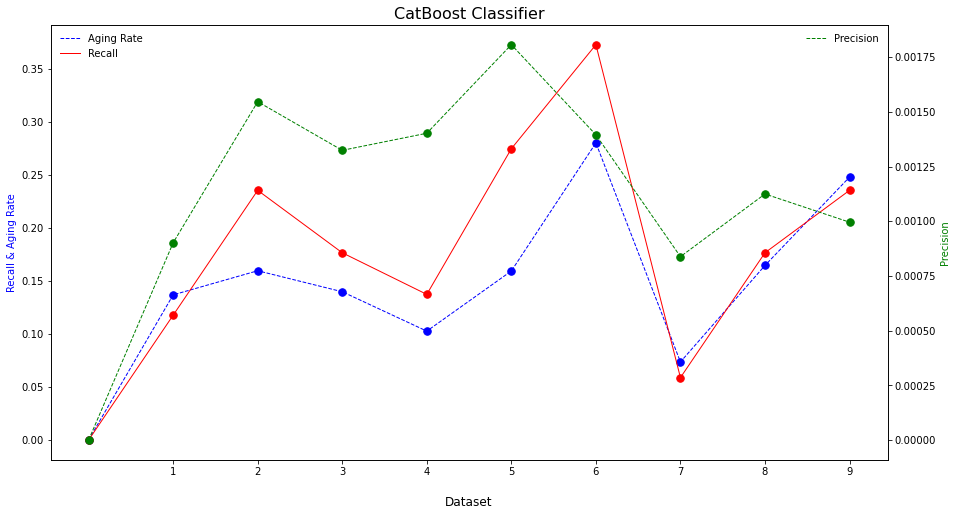

In [6]:
table_setC = runall_CatBoostC(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramC, cat_feature = [])
line_chart(table_setC, title = 'CatBoost Classifier')

In [7]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,515.934211,156844.0,304.0,0.0,5.0,51.0,48593.0,0.000000,0.000000,0.000103,0.000000,0.000000
dataset 1,1.000000,3067.0,3067.0,6.0,6650.0,45.0,41948.0,0.000901,0.117647,0.136817,0.859888,0.000000
dataset 2,1.000000,4207.0,4207.0,12.0,7749.0,39.0,40849.0,0.001546,0.235294,0.159531,1.474916,0.213225
dataset 3,1.000000,3336.0,3336.0,9.0,6789.0,42.0,41809.0,0.001324,0.176471,0.139736,1.262889,0.144113
dataset 4,1.000000,3038.0,3038.0,7.0,4986.0,44.0,43612.0,0.001402,0.137255,0.102633,1.337335,0.116531
dataset 5,1.006623,3040.0,3020.0,14.0,7735.0,37.0,40863.0,0.001807,0.274510,0.159284,1.723400,0.275026
dataset 6,0.719016,3040.0,4228.0,19.0,13602.0,32.0,34996.0,0.001395,0.372549,0.279985,1.330603,0.315224
dataset 7,1.000000,3040.0,3040.0,3.0,3577.0,48.0,45021.0,0.000838,0.058824,0.073588,0.799359,0.000000
dataset 8,1.000000,3040.0,3040.0,9.0,7995.0,42.0,40603.0,0.001124,0.176471,0.164525,1.072603,0.128613
dataset 9,10.000000,3040.0,304.0,12.0,12042.0,39.0,36556.0,0.000996,0.235294,0.247775,0.949629,0.000000


### Regressor

In [ ]:
pr_dict, table_setR = runall_CatBoostR(10, trainset_x, run_test_x, trainset_y, run_test_y, best_paramR, cat_feature = [], 
                                       thres_target = 'Recall', threshold = 0.8)
line_chart(table_setR, title = 'CatBoost Regressor')

In [ ]:
multiple_curve(4, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(4, 3, pr_dict, table_setR, target = 'Precision')
table_setR

### export

In [9]:
savedate = '20211214'
TPE_multi = True

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'CatBoost'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'CatBoost')